# Análisis de datos de expresión diferencial por qPCR para identificar firmas génicas y redes de interacción en cánceres específicos

Este pipeline de análisis toma datos experimentales de qPCR para identificar genes diferencialmente expresados. A partir de estos genes, se realiza una búsqueda bibliográfica, asociándolos a tipos específicos de cáncer y a un contexto definido, como la transición epitelio-mesénquima o perfiles de mRNAs. Además, se generan mapas de calor (heatmaps) para visualizar la expresión génica y se construyen redes de interacción genética, con el objetivo de identificar genes clave (genes hub) que podrían desempeñar un papel central en las vías biológicas relacionadas con el cáncer. Este contexto es flexible y puede ser editado según el objetivo de la investigación.

## Definición del contexto biológico de estudio, método de normalización, cáncer de interés y ruta del archivo a los datos crudos

### Configuración de carpetas de resultados

In [1]:
# notebooks/analisis.ipynb
import sys
from pathlib import Path
sys.path.append("../src")

from config import cargar_configuracion, configurar_rutas, montar_google_drive
from save_results import export_dfs_to_excel, guardar_grafico, set_export_folder
from messaging import result_message, success_message, error_message, resume_message

# Cargar configuración
config = cargar_configuracion('../config miRNAs.yaml')
rutas = configurar_rutas(config)
montar_google_drive(config)

# Obtener parámetros principales
ruta_archivo = config['rutas']['datos_crudos']
contexto_biologico = config['analisis']['contexto_biologico']
metodo_elegido = config['analisis']['metodo_normalizacion']
tipo_cancer = config['analisis']['tipo_cancer']
nombre_controles = config['analisis']['nombre_controles']
nombre_muestras = config['analisis']['nombre_muestras']


# Validar existencia del archivo de datos
if not Path(ruta_archivo).exists():
    raise FileNotFoundError(f"Archivo de datos no encontrado: {ruta_archivo}")

# Generar estructura de carpetas
nombre_archivo = Path(ruta_archivo).stem
ruta_resultados = Path(
    f"{config['rutas']['resultados_base']}/"
    f"{nombre_archivo}/"
    f"{contexto_biologico}/"
    f"{metodo_elegido}/"
    f"{tipo_cancer}/"
)
ruta_resultados.mkdir(parents=True, exist_ok=True)
set_export_folder(ruta_resultados)

# ==================================================
# VISUALIZACIÓN DE CONFIGURACIÓN
# ==================================================

success_message("Configuración cargada desde YAML")

# Mostrar parámetros
resume_message({
    "Contexto biológico": contexto_biologico,
    "Método de normalización": metodo_elegido,
    "Tipo de cáncer": tipo_cancer,
    "Controles": nombre_controles,
    "Muestras": nombre_muestras
})

success_message("Configuración de las variables de análisis cargadas correctamente")

# Mostrar rutas

resume_message({
    "Archivo de datos": ruta_archivo,
    "Directorio de resultados": ruta_resultados
})
success_message("Configuración de rutas cargadas correctamente")

# Verificación final

success_message("✓ Configuración válida" if config else "✗ Error en configuración")



FileNotFoundError: Archivo no encontrado: ../raw_data/miRNAs.xlsx

## Importación de librerías esenciales para el análisis de expresión génica

Este bloque de código importa una serie de librerías fundamentales para realizar análisis avanzados en el contexto de la expresión génica.


In [3]:
# Celda 1: Importación de módulos
import sys
sys.path.append("../src")  # Si los módulos están en subdirectorio

from setup_environment import configure_environment
from messaging import result_message, success_message

# Celda 2: Configuración inicial
configure_environment()


## Limpieza de datos


### Definición de los nombres de los controles y las muestras


### Carga del archivo de Excel y extracción de información

En esta sección se realiza la carga de un archivo de Excel que contiene los datos de Ct de diversas pruebas. El proceso se divide en dos pasos fundamentales:

1. **Carga del archivo de Excel**  
   Se define una función llamada `cargar_datos_excel` que recibe como argumento la ruta del archivo. La función intenta cargar el archivo utilizando `pandas.read_excel` y maneja posibles errores.
   
   Si el archivo se carga correctamente, se muestra un mensaje de éxito; de lo contrario, se interrumpe la ejecución del programa.

2. **Extracción de información relevante**  
   La función `extraer_informacion` se encarga de extraer tres elementos importantes del DataFrame cargado: Nombres de las pruebas, Pozos y Genes objetivo.

Finalmente, se muestran los resultados de la extracción en pantalla, confirmando que el proceso se ha llevado a cabo correctamente.

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, Markdown
from messaging import (alert_message, error_message,
                      success_message, resume_message)

# ==================================================
# FUNCIÓN DE CARGA DE DATOS MEJORADA
# ==================================================
def cargar_datos_excel(ruta):
    """
    Carga un archivo Excel con manejo robusto de errores y resumen automático
    """
    try:
        df = pd.read_excel(ruta, engine='openpyxl')

        # Resumen detallado del archivo cargado
        resume_message({
            "Archivo": Path(ruta).name,
            "Formato": f"{df.shape[0]} filas × {df.shape[1]} columnas",
            "Memoria": f"{df.memory_usage().sum() / 1024**2:.2f} MB",
            "Columnas": ", ".join(df.columns[:3]) + ("..." if len(df.columns)>3 else "")
        }, title="📦 Datos cargados")

        return df

    except FileNotFoundError:
        error_message(f"Archivo no encontrado: {ruta}")
    except Exception as e:
        error_message(f"Error en carga: {str(e)}")
    return None

# ==================================================
# FUNCIÓN DE EXTRACCIÓN DE METADATOS
# ==================================================
def extraer_informacion_cg(df: pd.DataFrame) -> tuple:
    """Extrae metadatos clave con validación integrada"""
    if df.shape[0] < 4 or df.shape[1] < 2:
        alert_message("Formato inválido: Mínimo 4 filas × 2 columnas requeridas")
        return [], [], []

    test_names = df.iloc[0].dropna().astype(str).tolist()
    pozos = df.iloc[2:, 0].dropna().astype(str).tolist()
    genes = df.iloc[3:, 1].dropna().astype(str).tolist()

    # Resumen estadístico de la extracción
    resume_message({
        "Pruebas": len(test_names),
        "Pozos": f"{len(pozos)} (únicos: {len(set(pozos))})",
        "Genes": f"{len(genes)} (únicos: {len(set(genes))})",
        "Ejemplo gen": genes[0] if genes else "N/A"
    }, title="🔍 Metadatos extraídos")

    return test_names, pozos, genes

# ==================================================
# PROCESAMIENTO DE VALORES CT (OPTIMIZADO)
# ==================================================
def procesar_ct(df: pd.DataFrame, genes: list,
               nombre_controles: str, nombre_muestras: str) -> tuple:
    """Clasificación inteligente de datos CT con reporte automático"""
    if len(df) <= 2:
        alert_message("Insuficientes filas para procesar CT")
        return pd.DataFrame(), pd.DataFrame()

    fila_ct = df.iloc[2]
    if "CT" not in fila_ct.values:
        alert_message("No se encontraron columnas con valores CT")
        return pd.DataFrame(), pd.DataFrame()

    clasificacion = {
        'controles': [],
        'muestras': [],
        'omitidos': []
    }

    # Contenedores para DataFrames
    controles_list = []
    muestras_list = []

    for idx in np.where(fila_ct == "CT")[0]:
        nombre_test = str(df.iloc[0, idx]) if idx < df.shape[1] else f"Test_{idx}"

        # Construcción correcta de los DataFrames
        df_temp = pd.DataFrame({
            'test': [nombre_test] * len(genes),
            'target': genes,
            'ct': df.iloc[3:, idx].tolist()
        })

        if nombre_test.startswith(nombre_controles):
            clasificacion['controles'].append(nombre_test)
            controles_list.append(df_temp)
        elif nombre_test.startswith(nombre_muestras):
            clasificacion['muestras'].append(nombre_test)
            muestras_list.append(df_temp)
        else:
            clasificacion['omitidos'].append(nombre_test)

    # Generación de reporte de clasificación
    resume_message({
        "Controles": f"{len(clasificacion['controles'])} pruebas",
        "Muestras": f"{len(clasificacion['muestras'])} pruebas",
        "Omitidos": f"{len(clasificacion['omitidos'])} ítems",
        "Ejemplo Control": clasificacion['controles'][0][:20] + "..." if clasificacion['controles'] else "N/A",
        "Ejemplo Muestra": clasificacion['muestras'][0][:20] + "..." if clasificacion['muestras'] else "N/A"
    }, title="🧪 Clasificación CT")

    if clasificacion['omitidos']:
        alert_message(f"Datos omitidos: {', '.join(clasificacion['omitidos'][:3])}{'...' if len(clasificacion['omitidos'])>3 else ''}")

    # Concatenación correcta de los datos
    controles_df = pd.concat(controles_list, ignore_index=True) if controles_list else pd.DataFrame()
    muestras_df = pd.concat(muestras_list, ignore_index=True) if muestras_list else pd.DataFrame()

    return controles_df, muestras_df

# ==================================================
# FLUJO PRINCIPAL (CON REPORTES INTEGRADOS)
# ==================================================
def flujo_procesamiento(ruta_archivo: str,
                       nombre_controles = nombre_controles,
                       nombre_muestras = nombre_muestras) -> dict:
    """
    Pipeline completo con telemetría mejorada
    Devuelve: {
        'metadata': dict,
        'dataframes': dict,
        'stats': dict
    }
    """
    # Etapa 1: Carga inteligente
    df = cargar_datos_excel(ruta_archivo)
    if df is None:
        raise SystemExit("Error crítico: Carga de datos fallida")

    # Etapa 2: Extracción de metadatos
    test_names, pozos, genes = extraer_informacion_cg(df)

    # Etapa 3: Procesamiento CT
    controles_df, muestras_df = procesar_ct(df, genes, nombre_controles, nombre_muestras)

    # Reporte consolidado final
    resume_message({
        "Total pruebas": len(test_names),
        "Pozos válidos": len(pozos),
        "miRNAS únicos": len(set(genes)),
        "Datos controles": f"{len(controles_df)} registros" if not controles_df.empty else "0 (⚠️)",
        "Datos muestras": f"{len(muestras_df)} registros" if not muestras_df.empty else "0 (⚠️)"
    }, title="📊 Resumen Final")

    success_message("Procesamiento completado ✓")

    return {
        'metadata': {
            'tests': test_names,
            'pozos': pozos,
            'genes': genes
        },
        'dataframes': {
            'controles': controles_df,
            'muestras': muestras_df
        },
        'stats': {
            'total_ct': len(controles_df) + len(muestras_df),
            'genes_unicos': len(set(genes))
        }
    }

resultados = flujo_procesamiento(ruta_archivo)

# Asignamos los DataFrames resultantes para su uso posterior.

controles_df = resultados['dataframes']['controles']
muestras_df = resultados['dataframes']['muestras']


In [5]:
controles_df.head()

,test,target,ct
0,7BSC-158,hsa-let-7a-5p,NaN
1,7BSC-158,hsa-miR-1-3p,NaN
2,7BSC-158,hsa-miR-100-5p,43.38
3,7BSC-158,hsa-miR-106b-5p,NaN
4,7BSC-158,hsa-miR-10b-5p,43.55


### Procesamiento de valores Ct indeterminados

Esta sección del código se encarga de procesar los valores de **Ct** en los dataframes de controles y muestras, reemplazando valores indeterminados y asegurando que la columna de Ct esté en formato numérico adecuado, si hay datos faltantes estos se eliminan para no agregar ruido a los cálculos

In [6]:
import pandas as pd
from IPython.display import display, Markdown

def procesar_ct_column(df1, df2, columna_ct='ct'):
    """
    Imputa 'Undetermined' y valores faltantes con el valor máximo encontrado en ambas columnas Ct.

    Args:
        df1, df2: DataFrames con columna 'ct'
        columna_ct: nombre de la columna Ct

    Returns:
        df1, df2: con imputación lista
    """
    def procesar(df, columna):
        # Reemplazar 'Undetermined' por NaN
        df[columna] = df[columna].replace('Undetermined', pd.NA)
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        return df

    # Paso 1: Reemplazo y conversión
    df1 = procesar(df1, columna_ct)
    df2 = procesar(df2, columna_ct)

    # Paso 2: Encontrar el valor máximo observado entre ambos DF (sin contar NaN)
    valor_maximo = pd.concat([df1[columna_ct], df2[columna_ct]]).max()

    # Paso 3: Imputar NaNs con ese valor
    df1[columna_ct] = df1[columna_ct].fillna(valor_maximo)
    df2[columna_ct] = df2[columna_ct].fillna(valor_maximo)

    # Paso 4: Mostrar resumen
    display(Markdown("### Procesamiento completado"))
    display(Markdown(f"- Valor máximo usado para imputación: **{valor_maximo}**"))
    return df1, df2

# Procesamos los DataFrames de controles y muestras
try:
    controles_df, muestras_df = procesar_ct_column(controles_df, muestras_df)
    success_message("Procesamiento de valores de Ct finalizado")
except Exception as e:
    error_message(f"Ocurrió un error en el procesamiento de valores de Ct: {e}")



### Procesamiento completado

- Valor máximo usado para imputación: **44.89**

### Filtrado de controles de máquina y concatenación de datos

En esta sección del código se realiza el filtrado de los controles de máquina de los dataframes y la concatenación de los resultados para obtener un dataframe combinado que clasifica las filas según su tipo (control o muestra).


In [7]:
def filtrar_controles_maquina(df, columna_target='target', controles_maquina=None):
    """
    Filtra las filas de un DataFrame eliminando aquellas que contienen controles de máquina,
    definidos como aquellos cuyo valor en la columna 'columna_target' comienza con alguno
    de los prefijos especificados en controles_maquina.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos a filtrar.
        columna_target (str): Nombre de la columna que contiene los targets (por defecto, 'target').
        controles_maquina (list, opcional): Lista de prefijos de controles de máquina a eliminar.
            Si no se proporciona, se utilizará la lista por defecto: ['PPC', 'RTC'].

    Returns:
        pd.DataFrame: DataFrame filtrado sin los controles de máquina.
    """
    # Lista por defecto de controles de máquina si no se proporciona
    if controles_maquina is None:
        controles_maquina = ['PPC', 'RTC', 'miRTC']

    alert_message(f"Controles de máquina a eliminar: {', '.join(controles_maquina)}")

    # Filtrado del DataFrame eliminando los controles de máquina que comienzan con alguno de los prefijos
    df_filtrado = df[~df[columna_target].str.startswith(tuple(controles_maquina))]
    success_message("Filas eliminadas con controles de máquina")

    return df_filtrado

# Filtrar los controles de máquina de los DataFrames
display(Markdown("### Filtrado de controles de máquina para los datos en controles"))
controles_df = filtrar_controles_maquina(controles_df)
display(Markdown("### Filtrado de controles de máquina para los datos en muestras"))
muestras_df = filtrar_controles_maquina(muestras_df)

# Añadir columna para identificar el tipo de cada fila
controles_df = controles_df.assign(tipo='Control')
muestras_df = muestras_df.assign(tipo='Muestra')

export_dfs_to_excel(
    [controles_df, muestras_df],
    ["datos_control_limpio", "datos_muestras_limpio"],
    "Datos limpios de controles y muestras: Archivo que contiene los datos de controles y muestras limpios, sin valores nulos ni controles de máquina.", ruta_resultados
)

### Filtrado de controles de máquina para los datos en controles

### Filtrado de controles de máquina para los datos en muestras

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/Datos limpios de controles y muestras.xlsx')

## Procesamiento de datos

### Análisis de expresión génica mediante CT y Fold Change utilizando las metodologías promedio CT de un gen de referencia y promedio global

#### Método con gen de referencia

1. Promedio de Ct para cada gen:

$$\text{Promedio } Ct_{\text{gen de referencia}} \hspace{5pt}= \frac{Ct_1 + Ct_2 + Ct_3 + ... +Ct_n}{n}$$

2. ΔCt para cada condición:

$$\Delta Ct = \text{Promedio } Ct_{\text{gen de interés}} \hspace{5pt}- \text{Promedio } Ct_{\text{gen de referencia}}$$

3. ΔΔCt:

$$\Delta\Delta Ct = \Delta Ct_{\text{muestra}} - \Delta Ct_{\text{control}}
$$

4. Fold Change:

$$\text{Fold Change} = 2^{-\Delta\Delta Ct}$$

#### Métdodo con promedio global

1. Promedio de Ct para cada gen:

$$
\text{Promedio } Ct_{\text{gen}} = \frac{Ct_1 + Ct_2 + Ct_3 + ... + Ct_n}{n}
$$

2. Promedio global de Ct para cada condición

$$
\text{Promedio global } Ct_{\text{condición}} \hspace{5pt}= \frac{\sum \text{Promedio } Ct_{\text{gen}}}{N}
$$

3. ΔCt para cada gen:

$$
\Delta Ct_{\text{gen}} = \text{Promedio } Ct_{\text{gen}} - \text{Promedio global } Ct_{\text{condición}}
$$

4. ΔΔCt para cada gen:

$$
\Delta\Delta Ct_{\text{gen}} = \Delta Ct_{\text{gen, tratamiento}} \hspace{5pt}- \Delta Ct_{\text{gen, control}}
$$

5. Fold Change:

$$
\text{Fold Change} = 2^{-\Delta\Delta Ct_{\text{gen}}}
$$

In [8]:
from typing import Tuple
import pandas as pd

def calcular_fold_change(
    controles: pd.DataFrame,
    muestras: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calcula el fold change usando los dataframes de controles y muestras.


    1. Agrupamos los datos por 'target' y calculamos la media y la desviación estándar (CT).
    2. Calculamos los delta CT comparando cada gen con el promedio general.
    3. Seleccionamos el gen más estable: el que tiene la menor variabilidad (promedio de desviaciones).
    4. Utilizamos este gen de referencia para normalizar y obtener el fold change.
    """

    # Función auxiliar para procesar cada grupo (controles o muestras) 🧪📊
    def procesar_grupo(df: pd.DataFrame, grupo: str) -> pd.DataFrame:
        # Agrupamos por gen y calculamos estadísticas básicas
        stats = df.groupby('target', as_index=False).agg(
            ct_promedio=('ct', 'mean'),
            ct_std=('ct', 'std')
        ).rename(columns={
            'ct_promedio': f'ct_promedio_{grupo}',
            'ct_std': f'ct_std_{grupo}'
        })
        return stats

    # Procesamos los dataframes de controles y muestras
    stats_controles = procesar_grupo(controles, 'controles')
    stats_muestras = procesar_grupo(muestras, 'muestras')

    # Calculamos el promedio general de CT para cada grupo 📈
    stats_controles['promedio_general_controles'] = stats_controles['ct_promedio_controles'].mean()
    stats_muestras['promedio_general_muestras'] = stats_muestras['ct_promedio_muestras'].mean()

    # Calculamos el delta CT con respecto al promedio general 🧮
    stats_controles['delta_ct_promedio_controles'] = stats_controles['ct_promedio_controles'] - stats_controles['promedio_general_controles']
    stats_muestras['delta_ct_promedio_muestras'] = stats_muestras['ct_promedio_muestras'] - stats_muestras['promedio_general_muestras']

    # Merge inicial de controles y muestras en un solo dataframe 🔀
    df_consolidado = pd.merge(
        stats_controles,
        stats_muestras,
        on='target',
        how='outer',  # Se mantienen todos los targets 🤝
        suffixes=('_controles', '_muestras')
    )

    # Selección del gen más estable 🔬📉:
    # Se define la estabilidad como el promedio de las desviaciones estándar de controles y muestras
    df_consolidado['stability'] = (df_consolidado['ct_std_controles'] + df_consolidado['ct_std_muestras']) / 2
    gen_mas_estable = df_consolidado.loc[df_consolidado['stability'].idxmin(), 'target']


    # Muestra una alerta con el gen de referencia seleccionado 🚨✨
    # alert_message debe estar definida en otro lugar con la siguiente estructura:
    # def alert_message(text):
    #     """
    #     Muestra un mensaje de alerta.
    #
    #     Args:
    #         text (str): Texto del mensaje.
    #     """
    alert_message(f"miRNA de referencia seleccionado: {gen_mas_estable} ")

    # Cálculo del delta CT respecto al gen de referencia (más estable) 🎯
    ref_controles = stats_controles.query("target == @gen_mas_estable")['ct_promedio_controles'].values[0]
    ref_muestras = stats_muestras.query("target == @gen_mas_estable")['ct_promedio_muestras'].values[0]

    stats_controles['delta_ct_gen_ref_controles'] = stats_controles['ct_promedio_controles'] - ref_controles
    stats_muestras['delta_ct_gen_ref_muestras'] = stats_muestras['ct_promedio_muestras'] - ref_muestras

    # Merge final para incorporar los cálculos de fold change 🔗
    df_consolidado = pd.merge(
        stats_controles,
        stats_muestras,
        on='target',
        how='outer',
        suffixes=('_controles', '_muestras')
    )

    # Cálculo del fold change utilizando el método del promedio 📊🏎️
    df_consolidado['delta_delta_ct_promedio'] = (
        df_consolidado['delta_ct_promedio_muestras'] - df_consolidado['delta_ct_promedio_controles']
    )
    df_consolidado['fold_change_promedio'] = 2 ** (-df_consolidado['delta_delta_ct_promedio'])

    # Cálculo del fold change utilizando el método del gen de referencia 🎯🔢
    df_consolidado['delta_delta_ct_gen_ref'] = (
        df_consolidado['delta_ct_gen_ref_muestras'] - df_consolidado['delta_ct_gen_ref_controles']
    )
    df_consolidado['fold_change_gen_ref'] = 2 ** (-df_consolidado['delta_delta_ct_gen_ref'])

    # Preparación de dataframes especializados para exportar 📑
    cols_promedio = ['target'] + [c for c in df_consolidado.columns if 'promedio' in c]
    cols_gen_ref = ['target'] + [c for c in df_consolidado.columns if 'gen_ref' in c]

    df_promedios = df_consolidado[cols_promedio].copy()
    df_promedios.rename(columns={'fold_change_promedio': 'fold_change'}, inplace=True)
    df_gen_ref = df_consolidado[cols_gen_ref].copy()
    df_gen_ref.rename(columns={'fold_change_gen_ref': 'fold_change'}, inplace=True)

    success_message("Cálculo de fold change finalizado 🚀")

    return df_consolidado, df_promedios, df_gen_ref, gen_mas_estable


# Ejemplo de uso:
# Se asume que controles_df y muestras_df ya están definidos
df_consolidado, df_promedios, df_gen_ref, gen_referencia= calcular_fold_change(controles_df, muestras_df)

# Exportar todos los dataframes a un archivo Excel 📤📊
export_dfs_to_excel(
    [df_consolidado, df_promedios, df_gen_ref],
    ['consolidado_promedios_y_gen_ref', 'fc_metodo_promedios', 'fc_metodo_gen_ref'],
    "Calculo de fold change: Archivo que contiene los cálculos realizados y los valores de fold change por método."
)



PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/Calculo de fold change.xlsx')

### Tabla comparativa de métodos de calculo de fold change

Este código genera una tabla interactiva en Python usando Plotly. Procesa los valores de "fold change" para cada gen y ajusta los estilos de manera dinámica, calculando el ancho de columnas en función del contenido y aplicando colores condicionales según los umbrales definidos. También ajusta la altura de las filas y el layout de la tabla para mejorar la visualización.

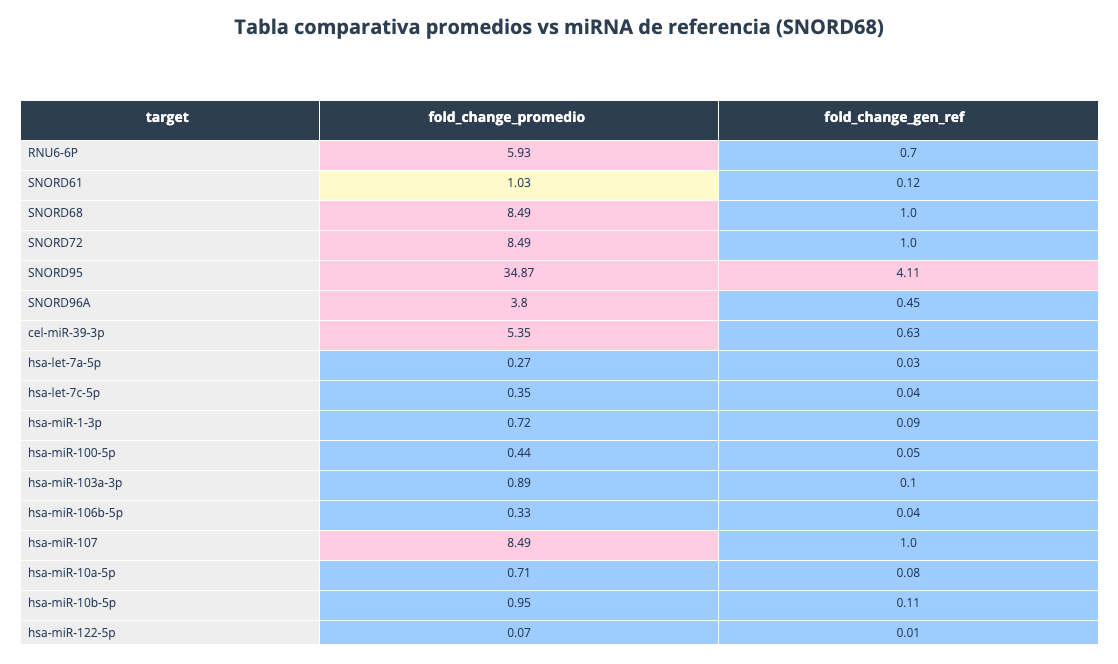

In [9]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Configuración actualizada con ajustes de ancho
SETTINGS = {
    "color_thresholds": [1, 2],
    "colors": ['#9fccff', '#FFFBCA', '#FFCCE1'],
    "header_style": {
        "fill_color": '#2C3E50',
        "font_color": 'white',
        "align": ['center', 'center', 'center'],
        "font_size": 14,
        "height": 40
    },
    "cell_style": {
        "font_size": 12,
        "align": ['left', 'center', 'center'],
        "height": 30
    },
    "decimals": 2,
    "char_width": 7,         # Pixeles por carácter
    "min_column_width": 60,  # Ancho mínimo reducido
    "max_column_width": 200,  # Límite máximo ajustado

    "row_height": 35,         # Altura por fila
    "header_height": 40,      # Altura del encabezado
    "base_height": 300        # Altura base para título y márgenes
}

def prepare_data(df):
    return (df[['target', 'fold_change_promedio', 'fold_change_gen_ref']]
            .sort_values(by='target', ascending=True)
            .assign(
                fold_change_promedio=lambda x: x['fold_change_promedio'].round(SETTINGS['decimals']),
                fold_change_gen_ref=lambda x: x['fold_change_gen_ref'].round(SETTINGS['decimals'])
            ))

def calculate_colors(series):
    return np.select(
        [series > SETTINGS["color_thresholds"][1],
         series > SETTINGS["color_thresholds"][0]],
        SETTINGS["colors"][::-1][:2],
        SETTINGS["colors"][0]
    )

def calculate_column_widths(df):
    col_widths = []
    for col in df.columns:
        # Longitud máxima entre encabezado y contenido
        max_header_length = len(str(col))
        max_content_length = df[col].astype(str).apply(len).max()
        max_length = max(max_header_length, max_content_length)

        # Cálculo de ancho con nuevos parámetros
        calculated_width = max_length * SETTINGS["char_width"]
        final_width = np.clip(calculated_width,
                            SETTINGS["min_column_width"],
                            SETTINGS["max_column_width"])

        col_widths.append(final_width)

    return col_widths

def create_interactive_table(df):
    # Convertir datos a strings para mejor cálculo
    df_display = df.copy()
    for col in ['fold_change_promedio', 'fold_change_gen_ref']:
        df_display[col] = df_display[col].astype(str)

    metadata = {
        "columns": df_display.columns.tolist(),
        "promedio_colors": calculate_colors(df['fold_change_promedio']),
        "gen_ref_colors": calculate_colors(df['fold_change_gen_ref']),
        "values": [df_display[col] for col in df_display.columns]
    }

    fig = go.Figure(data=[go.Table(
        columnwidth=calculate_column_widths(df_display),
        header=dict(
            values=[f"<b>{col}</b>" for col in metadata["columns"]],
            **SETTINGS["header_style"],
            font=dict(
                size=SETTINGS["header_style"]["font_size"],
                color=SETTINGS["header_style"]["font_color"]
            )
        ),
        cells=dict(
            values=metadata["values"],
            fill_color=[
                ['#EEEEEE']*len(df),
                metadata["promedio_colors"],
                metadata["gen_ref_colors"]
            ],
            **SETTINGS["cell_style"],
            font=dict(size=SETTINGS["cell_style"]["font_size"])
        )
    )])

    # Ajustes finales del layout
    fig.update_layout(
        title={
            'text': f'<b>Tabla comparativa promedios vs miRNA de referencia ({gen_referencia})</b>',
            'y': 0.97,
            'x': 0.5,
            'xanchor': 'center',
            'font': dict(size=20, color='#2C3E50')
        },
        margin=dict(t=100, b=20, l=20, r=20),
        paper_bgcolor='white',
        autosize=False,  # Desactivar autoajuste global para priorizar nuestros cálculos
        height=300 + len(df)*4
    )

    return fig

# Datos de prueba con diferentes longitudes
df_fold_change = df_consolidado[['target', 'fold_change_promedio', 'fold_change_gen_ref']]

df_processed = prepare_data(df_fold_change)
fig = create_interactive_table(df_processed)
fig.show(config={'responsive': False})  # Desactivar responsive para forzar nuestros anchos

### Análisis comparativo de métodos de cálculo


Este código crea una visualización combinada en Plotly que compara valores de ΔΔCT (barra) y Fold Change (línea), usando dos ejes Y. Los valores de ΔΔCT se representan en un eje Y izquierdo, mientras que los valores de Fold Change se trazan en el eje Y derecho con una escala logarítmica. Además:

- **Barras para ΔΔCT**: Comparan promedios y valores de genes de referencia.
- **Líneas y marcadores para Fold Change**: Usan diferentes colores y formas para distinguir entre promedios y genes de referencia.
- **Layout personalizado**: Incluye títulos, leyenda mejorada, anotaciones clave, y un esquema de colores claro.

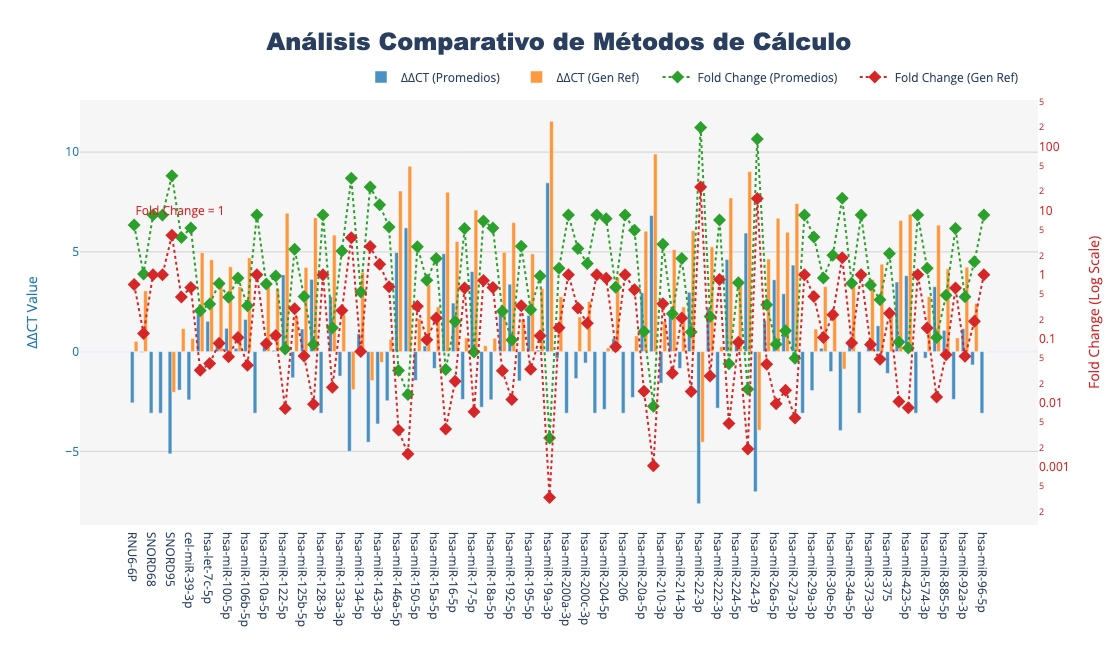

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/analisis_comparativo.png')

In [10]:
import plotly.graph_objects as go

fig = go.Figure()

# =============================================================================
# 1. Barras para Delta-Delta CT (Eje Y Izquierdo)
# =============================================================================
fig.add_trace(go.Bar(
    x=df_consolidado['target'],
    y=df_consolidado['delta_delta_ct_promedio'],
    name='ΔΔCT (Promedios)',
    marker_color='#1f77b4',  # Azul estándar
    opacity=0.8,
    yaxis='y'
))

fig.add_trace(go.Bar(
    x=df_consolidado['target'],
    y=df_consolidado['delta_delta_ct_gen_ref'],
    name='ΔΔCT (Gen Ref)',
    marker_color='#ff7f0e',  # Naranja estándar
    opacity=0.8,
    yaxis='y'
))

# =============================================================================
# 2. Líneas + Marcadores para Fold Change (Eje Y Derecho - Escala Log)
# =============================================================================
fig.add_trace(go.Scatter(
    x=df_consolidado['target'],
    y=df_consolidado['fold_change_promedio'],
    name='Fold Change (Promedios)',
    mode='markers+lines',
    marker=dict(color='#2ca02c', size=10, symbol='diamond'),  # Verde
    line=dict(color='#2ca02c', width=2, dash='dot'),
    yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=df_consolidado['target'],
    y=df_consolidado['fold_change_gen_ref'],
    name='Fold Change (Gen Ref)',
    mode='markers+lines',
    marker=dict(color='#d62728', size=10, symbol='diamond'),  # Rojo
    line=dict(color='#d62728', width=2, dash='dot'),
    yaxis='y2'
))

# =============================================================================
# 3. Ajustes de Layout
# =============================================================================
fig.update_layout(
    title=dict(
        text='Análisis Comparativo de Métodos de Cálculo',
        font=dict(size=24, family='Arial Black'),
        x=0.5
    ),
    template='plotly_white',
    barmode='group',
    yaxis=dict(
        title='ΔΔCT Value',
        titlefont=dict(color='#1f77b4', size=14),
        tickfont=dict(color='#1f77b4'),
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis2=dict(
        title='Fold Change (Log Scale)',
        titlefont=dict(color='#d62728', size=14),
        tickfont=dict(color='#d62728'),
        overlaying='y',
        side='right',
        type='log',
        showgrid=False
    ),
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        bgcolor='rgba(255,255,255,0.9)'
    ),
    height=650,
    width=1200,
    margin=dict(b=100, t=100),
    plot_bgcolor='rgba(245,245,245,0.9)'
)

# =============================================================================
# 4. Anotaciones Clave
# =============================================================================
fig.add_annotation(
    text="Fold Change = 1",
    xref="paper", yref="y2",
    x=0.05, y=1,
    showarrow=False,
    font=dict(color="#d62728", size=12)
)

fig.show()


guardar_grafico(fig, 'analisis_comparativo.png')

### Filtrado y Clasificación de Genes por Niveles de Expresión

Este código clasifica los genes en tres categorías según su **Fold Change** (cambio en la expresión génica) ademas nos permite elegir los valores con cuales trabajar según el método de cálculo de valor de fold change:  

1. **Genes sobreexpresados**: Fold Change >= 2.  
2. **Genes estables**: Fold change entre 1 y 2.  
3. **Genes subexpresados**: Fold Change < 1.  

Además, realiza la misma clasificación normalizando los datos con un **gen de referencia** (`gen_referencia`). Los resultados se guardan en un archivo Excel y se muestran en un resumen visual con los genes clasificados en cada categoría.  

In [11]:

if metodo_elegido == "miRNA de referencia":
    result_message(f"Se ha elegido: el método de normalizado por {metodo_elegido} por {gen_referencia}")
else:
    result_message(f"Se ha elegido: el método de normalizado por {metodo_elegido} el cual normaliza los datos mediante el promedio de todos los valores de CT")


In [12]:
def categorizar_expresion(df, umbral_bajo=1, umbral_alto=2):
    # Validación de columnas
    required_cols = ['target', 'fold_change']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Columnas requeridas no encontradas")

    # Categorización vectorizada
    condiciones = [
        (df['fold_change'] < umbral_bajo),
        (df['fold_change'] >= umbral_bajo) & (df['fold_change'] < umbral_alto),
        (df['fold_change'] >= umbral_alto)
    ]

    categorias = ['subexpresado', 'estable', 'sobreexpresado']

    df_categorizado = df[required_cols].copy()
    df_categorizado['nivel_expresion'] = np.select(condiciones, categorias, default='sin_categorizar')
    df_categorizado.sort_values('fold_change', ascending=False)

    return df_categorizado

if metodo_elegido == "gen de referencia":
    df_combined_expresion = categorizar_expresion(df_gen_ref)
else:
    df_combined_expresion = categorizar_expresion(df_promedios)


# Extraemos df separados por categoría con su respectivo target y valor de fold change

df_sobreexpresados = df_combined_expresion[df_combined_expresion['nivel_expresion'] == 'sobreexpresado'][['target']]
lista_sobreexpresados = df_sobreexpresados['target'].tolist()

df_estables = df_combined_expresion[df_combined_expresion['nivel_expresion'] == 'estable'][['target']]
lista_estables = df_estables['target'].tolist()

df_subexpresados = df_combined_expresion[df_combined_expresion['nivel_expresion'] == 'subexpresado'][['target']]
lista_subexpresados = df_subexpresados['target'].tolist()

export_dfs_to_excel(
    [df_combined_expresion, df_sobreexpresados, df_estables, df_subexpresados],
    ['niveles_expresion_genes', 'sobreexpresados', 'estables', 'subexpresados'],
    "Niveles de expresión: Archivo que contiene los genes categorizados por nivel de expresión, separados por categoría."
)


PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/Niveles de expresión.xlsx')

### Resumen de niveles de expresión

In [13]:
# Mostrar resultados
display(Markdown("### Resumen de niveles de expresión génica"))
alert_message(f"Se muestran las listas de expresión diferencial obtenida por el método de: {metodo_elegido}")

result_message(f"Genes sobreexpresados ({str(len(lista_sobreexpresados))}): {str(', '.join(lista_sobreexpresados))}")
result_message(f"Genes estables ({str(len(lista_estables))}): {str(', '.join(lista_estables))}")
result_message(f"Genes subexpresados ({str(len(lista_subexpresados))}): {str(', '.join(lista_subexpresados))}")



### Resumen de niveles de expresión génica

## Agregar Información de Ensembl en Lotes

Este código agrega información de **Ensembl** (IDs y descripciones) a un DataFrame que contiene nombres de genes. La consulta se realiza en lotes para evitar sobrecargar el servidor de Ensembl.  

**Funcionalidad**:  
1. **Consulta en Lotes**:  
   - Los genes se dividen en lotes de tamaño `batch_size` (por defecto, 50 genes por lote).  
   - Se realiza una solicitud HTTP POST a la API de Ensembl para obtener los IDs y descripciones de los genes en cada lote.  

2. **Manejo de Respuestas**:  
   - Si la consulta es exitosa, se extraen los IDs y descripciones de los genes.  
   - Si falla, se asigna "Not found" a los genes del lote.  

3. **Resultados**:  
   - Se agregan dos columnas al DataFrame: `ensembl_id` (ID de Ensembl) y `description` (descripción del gen).  

**Uso**:  
- Aplica la función `add_ensembl_info_batch` a DataFrames que contengan genes subexpresados, estables y sobreexpresados para enriquecerlos con información de Ensembl.  

In [14]:
# Eliminamos los prefijos de los nombres de los miRNAs para facilitar la lectura


df_sobreexpresados['target'] = df_sobreexpresados['target'].str.replace(r'^.*?(miR|let)', r'\1', regex=True)


df_subexpresados['target'] = df_subexpresados['target'].str.replace(r'^.*?(miR|let)', r'\1', regex=True)

In [15]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display, Markdown

def get_ensembl_id(gene_symbol):
    """Busca en Ensembl con tolerancia a alias y nombres alternativos"""
    base_url = "https://rest.ensembl.org"
    endpoints = [
        f"/lookup/symbol/homo_sapiens/{gene_symbol}?expand=1",
        f"/xrefs/symbol/homo_sapiens/{gene_symbol}?"
    ]

    for endpoint in endpoints:
        try:
            response = requests.get(base_url + endpoint, headers={"Content-Type": "application/json"})
            if response.status_code == 200:
                data = response.json()
                if isinstance(data, list):  # Para el endpoint xrefs
                    for item in data:
                        if item['type'] == 'gene':
                            return item['id'], item.get('description', 'No description')
                else:  # Para el endpoint lookup
                    return data['id'], data.get('description', 'No description')
        except Exception as e:
            continue

    # Si falla Ensembl, intentar con MyGene.Info
    mygene_response = requests.get(f"https://mygene.info/v3/query?q={gene_symbol}&species=human")
    if mygene_response.status_code == 200:
        results = mygene_response.json().get('hits', [])
        for hit in results:
            if 'ensembl' in hit:
                ensembl_id = hit['ensembl'].get('gene', 'Not found')
                description = hit.get('summary', 'No description')
                return ensembl_id, description

    return 'Not found', 'No description'

def process_gene(gene):
    """Función wrapper para procesamiento paralelo"""
    ensembl_id, description = get_ensembl_id(gene)

    # Búsqueda aproximada si no se encuentra
    if ensembl_id == 'Not found':
        try:
            fuzzy_response = requests.get(
                f"https://rest.ensembl.org/lookup/search/homo_sapiens?q={gene}",
                headers={"Content-Type": "application/json"},
                timeout=10
            )
            if fuzzy_response.status_code == 200:
                fuzzy_data = fuzzy_response.json()
                if fuzzy_data.get('hits'):
                    best_match = fuzzy_data['hits'][0]
                    return best_match['id'], best_match.get('description', 'No description')
        except:
            pass

    return ensembl_id, description

def add_ensembl_info_batch(df, max_workers=5):
    """Versión con procesamiento paralelo"""
    targets = df['target'].tolist()

    # Procesamiento paralelo
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_gene, targets))

    ids, descriptions = zip(*results)

    df['ensembl_id'] = ids
    df['description'] = descriptions

    # Estadísticas detalladas
    not_found = df[df['ensembl_id'] == 'Not found']
    if not not_found.empty:
        alert_message(f"miRNAs no encontrados ({len(not_found)}): {', '.join(not_found['target'].tolist()[:5])}" +
                     ("..." if len(not_found) > 5 else ""))
    else:
        success_message("¡Todos los miRNAs fueron encontrados exitosamente!")

    result_message(f"Resumen:\n- Total miRNAs: {len(df)}\n- Encontrados: {len(df) - len(not_found)}\n- No encontrados: {len(not_found)}")

    return df


# Función de alerta modificada
def display_alert_if_genes_not_found(df, dataset_name):
    not_found_genes = df[df['ensembl_id'] == 'Not found']
    if not not_found_genes.empty:
        alert_message(f"miRNAs no encontrados en {dataset_name}: {', '.join(not_found_genes['target'].unique()[:3])}..." +
                     f" ({len(not_found_genes)} totales)")
    else:
        success_message(f"Todos los miRNAs en {dataset_name} fueron encontrados en Ensembl.")

# Ejemplo de uso
display(Markdown("### Agregar Información de Ensembl a miRNAs Subexpresados"))
df_sobreexpresados = add_ensembl_info_batch(df_sobreexpresados, max_workers=8)
display_alert_if_genes_not_found(df_sobreexpresados, "miRNAs subexpresados")

display(Markdown("### Agregar Información de Ensembl a miRNAs Sobreexpresados"))
df_subexpresados = add_ensembl_info_batch(df_subexpresados, max_workers=8)
display_alert_if_genes_not_found(df_subexpresados, "miRNAs sobreexpresados")

df_sobreexpresados['nivel_expresion'] = 'Sobreexpresados'
df_subexpresados['nivel_expresion'] = 'Subexpresados'

df_emsamble_info = pd.concat([df_sobreexpresados, df_subexpresados], ignore_index=True)

# Exportar el DataFrame con información de Ensembl

export_dfs_to_excel(
    [df_emsamble_info],
    ["informacion_ensembl_genes"],
    "IDs y descripciones por miRNAs: Archivo que contiene la información de Ensembl para los miRNAs categorizados.")

### Agregar Información de Ensembl a miRNAs Subexpresados

### Agregar Información de Ensembl a miRNAs Sobreexpresados

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/IDs y descripciones por miRNAs.xlsx')

### Visualización de la distribución de niveles de expresión

> Aplica para las lista de genes

Antes de iniciar el enriquecimiento, veamos la distribución de los niveles de expresión

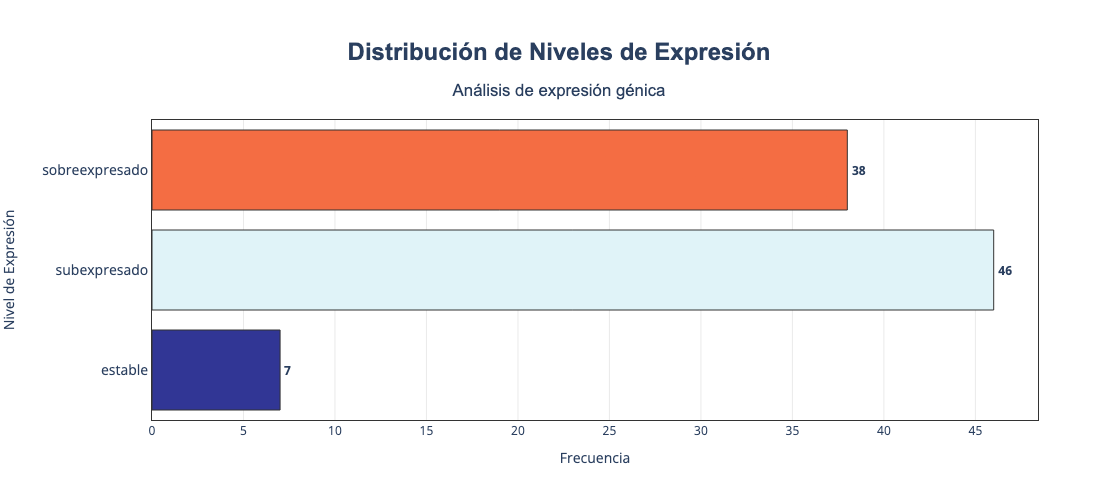

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/distribucion_niveles_expresion.png')

In [17]:
import plotly.graph_objects as go
from plotly.colors import sample_colorscale

# Orden deseado de las categorías
orden_niveles = ['estable', 'subexpresado',  'sobreexpresado']

# Calcular frecuencias y reindexar
expression_counts = df_combined_expresion['nivel_expresion'].value_counts()
expression_counts = expression_counts.reindex(orden_niveles, fill_value=0)

# Generar colores usando escala divergente nativa de Plotly
colors = sample_colorscale('RdYlBu_r', [0.0, 0.4, 0.8])  # Azul -> Amarillo -> Rojo

# Crear gráfico interactivo
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=expression_counts.index,
        x=expression_counts.values,
        orientation='h',
        marker=dict(
            color=colors,
            line=dict(color='#333', width=1)
        ),
        text=expression_counts.values,
        texttemplate='<b>%{text}</b>',
        textposition='outside',
        hovertemplate=(
            "<b>%{y}</b><br>"
            "Frecuencia: %{x}<br>"
            "<extra></extra>"
        )
    )
)

# Personalización avanzada
fig.update_layout(
    title=dict(
        text='<b>Distribución de Niveles de Expresión</b><br><sub>Análisis de expresión génica</sub>',
        x=0.5,
        font=dict(size=24, family='Arial')
    ),
    xaxis=dict(
        title='Frecuencia',
        showgrid=True,
        gridcolor='rgba(150,150,150,0.2)',
        linecolor='#333',
        mirror=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Nivel de Expresión',
        type='category',
        linecolor='#333',
        mirror=True,
        tickfont=dict(size=14)
    ),
    plot_bgcolor='white',
    height=500,
    width=1000,
    margin=dict(t=120, b=80, l=120),
    hoverlabel=dict(
        bgcolor='white',
        font_size=14,
        bordercolor='#333'
    )
)

fig.show()

guardar_grafico(fig, 'distribucion_niveles_expresion.png')

### Visualización de fold change por nivel de expresión

> datos: listas de genes

Este código genera una visualización en subplots para cada nivel de expresión génica (**Subexpresado**, **Estable**, **Sobreexpresado**), mostrando el **Fold Change** de los genes en cada categoría.


**Uso*:
- Esta visualización es útil para comparar el `fold_change` de los genes en cada nivel de expresión y identificar patrones o valores atípicos.  

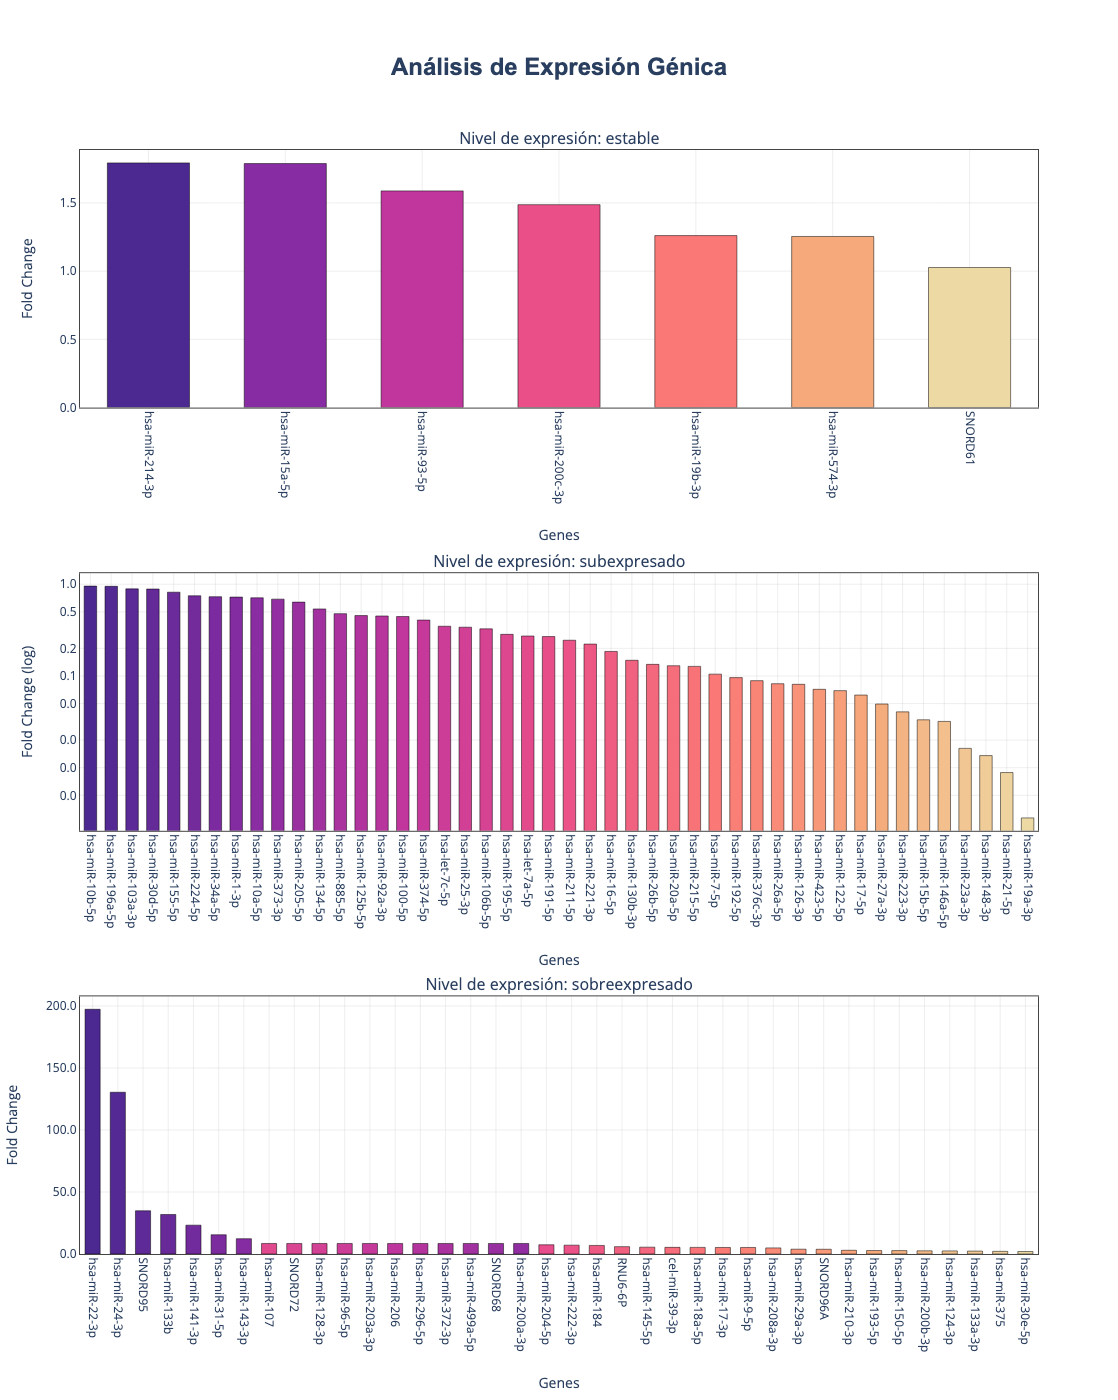

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/analisis_expresion_genica.png')

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import sample_colorscale, qualitative


# Filtrar solo los niveles que existen en los datos
unique_levels = [level for level in orden_niveles if level in df_combined_expresion['nivel_expresion'].unique()]
num_levels = len(unique_levels)

# Crear figura con subplots
fig = make_subplots(
    rows=num_levels,
    cols=1,
    subplot_titles=[f'Nivel de expresión: {level}' for level in unique_levels],
    vertical_spacing=0.15,
    specs=[[{"secondary_y": False}] for _ in range(num_levels)]
)

# Configurar estilo común
axis_style = dict(
    showgrid=True,
    gridcolor='rgba(200,200,200,0.3)',
    linecolor='#444',
    mirror=True,
    zeroline=False
)

for i, level in enumerate(unique_levels, 1):
    # Filtrar y ordenar datos
    data_subset = df_combined_expresion[df_combined_expresion['nivel_expresion'] == level]
    data_subset = data_subset.sort_values('fold_change', ascending=False)

    if data_subset.empty:
        continue

    num_bars = len(data_subset)

    # Generar colores con escala secuencial de Plotly
    if num_bars > 1:
        colors = sample_colorscale('Agsunset', [n/(num_bars-1) for n in range(num_bars)])
    else:
        colors = [qualitative.Plotly[0]]  # Color base de Plotly

    # Crear gráfico de barras
    fig.add_trace(
        go.Bar(
            x=data_subset['target'],
            y=data_subset['fold_change'],
            marker=dict(
                color=colors,
                line=dict(color='rgba(0,0,0,0.5)', width=1)
            ),
            name=level,
            hovertemplate=(
                "<b>%{x}</b><br>"
                "Fold Change: %{y:.2f}<br>"
                "Nivel: %{fullData.name}"
                "<extra></extra>"
            )
        ),
        row=i,
        col=1
    )

    # Configurar escalas
    min_val = data_subset['fold_change'].min()
    max_val = data_subset['fold_change'].max()

    yaxis_config = dict(
        type='log' if (max_val / min_val > 100 and min_val > 0) else 'linear',
        title='Fold Change (log)' if (max_val / min_val > 100) else 'Fold Change',
        tickformat=".1f",
        **axis_style
    )

    fig.update_yaxes(yaxis_config, row=i, col=1)
    fig.update_xaxes(
        title='Genes',
        tickangle=90,
        categoryorder='total descending',
        **axis_style,
        row=i,
        col=1
    )

# Configuración global del layout
fig.update_layout(
    height=400 * num_levels + 200,
    width=1200,
    title=dict(
        text='<b>Análisis de Expresión Génica</b>',
        x=0.5,
        font=dict(size=24, family='Arial')
    ),
    plot_bgcolor='white',
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family="Arial"
    ),
    margin=dict(t=150, b=100),
    showlegend=False,
    bargap=0.4  # Espaciado entre barras
)

# Añadir anotación de crédito
fig.add_annotation(
    text="Visualización generada con Plotly",
    xref="paper",
    yref="paper",
    x=0.5,
    y=-0.15,
    showarrow=False,
    font=dict(color='#666', size=10)
)

fig.show()

guardar_grafico(fig, 'analisis_expresion_genica.png')

### Construcción de un diccionario  de significados de categorías de enriquecimiento funcional

Este diccionario proporciona una descripción detallada de las categorías utilizadas en el análisis de enriquecimiento funcional. Cada categoría está asociada con un significado específico que ayuda a interpretar los resultados del análisis.

In [32]:
from IPython.display import display, Markdown, HTML

# Diccionario de significados de las categorías ampliado y detallado
categorias_significados = {
    "HPO": (
        "Human Phenotype Ontology: Un sistema de clasificación que describe los fenotipos observados en humanos. "
    ),
    "Process": (
        "Procesos biológicos generales asociados a los genes: Actividades celulares, fisiológicas o moleculares llevadas a cabo por uno o más genes."
    ),
    "PMID": (
        "Publicaciones científicas referenciadas mediante PubMed ID: Proporciona enlaces a estudios y artículos revisados por pares disponibles en PubMed."
    ),
    "RCTM": (
        "Reactome: Base de datos centrada en vías metabólicas y de señalización celular."
    ),
    "COMPARTMENTS": (
        "Localizaciones subcelulares y estructuras biológicas: Describe las ubicaciones dentro de la célula, como el núcleo, citoplasma, membrana plasmática y organelos."
    ),
    "WikiPathways": (
        "Rutas metabólicas y biológicas de la base WikiPathways: Una base de datos colaborativa que documenta y organiza rutas biológicas. "
    ),
    "KEGG": (
        "Rutas y procesos biológicos anotados en KEGG (Kyoto Encyclopedia of Genes and Genomes)."
    ),
    "Component": (
        "Componentes celulares asociados a los genes: Identifica las estructuras específicas dentro de la célula donde los genes o sus productos desempeñan un papel funcional."
    ),
    "TISSUES": (
        "Asociaciones específicas con tejidos biológicos: Describe la relación entre genes y su expresión preferencial o específica en tejidos como cerebro, hígado, pulmón o tejidos tumorales."
    ),
    "Keyword": (
        "Palabras clave relacionadas con las funciones genéticas: Etiquetas utilizadas para clasificar y agrupar genes según sus roles funcionales."
    ),
    "DISEASES": (
        "Relación con enfermedades humanas conocidas: Vincula genes y términos con patologías específicas como cáncer, enfermedades cardiovasculares o trastornos genéticos."
    ),
    "Function": (
        "Funciones moleculares de los genes: Define las actividades bioquímicas llevadas a cabo por los productos génicos, como proteínas y ARN."
    ),
    "NetworkNeighborAL": (
        "Genes conectados en redes de interacción cercanas: Representa la proximidad funcional o física de genes en redes biológicas."
    ),
    "SMART": (
        "Dominios específicos de proteínas anotados en SMART (Simple Modular Architecture Research Tool): Identifica regiones funcionales dentro de las proteínas."
    ),
    "InterPro": (
        "Clasificación y anotación de familias de proteínas: Integra múltiples bases de datos para identificar relaciones evolutivas y dominios funcionales en proteínas."
    ),
    "Pfam": (
        "Familias de proteínas definidas en la base Pfam: Ofrece información detallada sobre agrupaciones de proteínas relacionadas por secuencia y estructura."
    )
}

# Mostrar el diccionario de significados
display(Markdown("### Diccionario de Significados de Categorías"))

result_message("Diccionario de categorias cargado con exito")

### Diccionario de Significados de Categorías

### Análisis y exportación de estudios relacionados con cáncer y TEM o micro RNAs

Este bloque de código realiza el análisis de un conjunto de datos bibliográficos, permitiendo elegir la relación a investigar: **cáncer y transición epitelio-mesénquima (TEM)** o **cáncer y micro RNAs** (no de forma simultánea). A partir de la selección, se identifican los estudios relevantes y se exportan los resultados a un archivo Excel.

> **Nota**: Este código es útil para explorar tendencias en la literatura científica y facilita la organización y visualización de datos complejos en estudios genómicos.

#### Diccionario de tipos de cáncer y criterio adicional de búsqueda

A continuación, se define un diccionario que será utilizado en la clasificación automática basada en coincidencias dentro de los títulos o resúmenes de la bibliografía obtenida. Además, se incluye un criterio de búsqueda adicional que permite elegir entre **cáncer y TEM** o **cáncer y micro RNAs** para refinar los resultados.

In [33]:

cancer_type_keywords = {
    'Breast Cancer': [
        'breast', 'mammary', 'triple negative breast', 'er-positive',
        'pr-positive', 'ductal carcinoma', 'lobular carcinoma', 'estrogen receptor', 'progesterone receptor'
    ],
    'Melanoma': [
        'melanoma', 'cutaneous melanoma', 'skin melanoma', 'uveal melanoma', 'ocular melanoma',
        'acral melanoma', 'braf', 'braf mutation'
    ],
    'Colon Cancer': [
        'colon', 'colorectal', 'rectal', 'intestinal', 'intestine', 'colon adenocarcinoma',
        'rectal adenocarcinoma', 'lynch syndrome', 'hereditary colon cancer'
    ],
    'Hepatocellular Carcinoma': [
        'hepatocellular', 'hcc', 'liver cancer', 'hepatic carcinoma', 'hepatoma', 'cirrhosis',
        'hepatitis b', 'hbv', 'hepatitis c', 'hcv', 'fibrolamellar carcinoma', 'afp', 'alpha-fetoprotein'
    ],
    'Prostate Cancer': [
        'prostate', 'prostatic', 'prostate carcinoma', 'androgen receptor', 'ar-positive', 'psa',
        'prostate-specific antigen', 'gleason score', 'crpc', 'castration-resistant'
    ],
    'Lung Cancer': [
        'lung', 'pulmonary', 'bronchial', 'nsclc', 'non-small cell lung cancer', 'sclc',
        'small cell lung cancer', 'egfr mutation', 'alk rearrangement', 'lung adenocarcinma', 'lung squamous cell carcinoma', 'lung squamous'
    ],
    'Pancreatic Cancer': [
        'pancreatic', 'pancreas', 'pdac', 'ductal adenocarcinoma', 'pancreatic carcinoma',
        'neuroendocrine tumor', 'pancreatic neuroendocrine', 'pancreatic islet cell tumor', 'whipple procedure'
    ],
    'Leukemia': [
        'leukemia', 'leukaemia', 'aml', 'acute myeloid leukemia', 'acute lymphoblastic leukemia',
        'cll', 'chronic lymphocytic leukemia', 'cml', 'chronic myeloid leukemia', 'philadelphia chromosome',
        'bcr-abl', 'mpn', 'myeloproliferative neoplasm'
    ],
    'Lymphoma': [
        'lymphoma', 'hodgkin', 'non-hodgkin', 'nhl', 'b-cell lymphoma', 't-cell lymphoma',
        'dlbcl', 'diffuse large b-cell lymphoma', 'follicular lymphoma', 'mantle cell lymphoma',
        'burkitt lymphoma', 'cutaneous lymphoma'
    ],
    'Ovarian Cancer': [
        'ovarian', 'ovary', 'ovarian carcinoma', 'high-grade serous carcinoma', 'hgsc', 'brca1',
        'brca2', 'ca125', 'clear cell carcinoma', 'granulosa cell tumor'
    ],
    'Cervical Cancer': [
        'cervical', 'cervix', 'cervical carcinoma', 'cervical squamous cell carcinoma', 'cervical adenocarcinoma',
        'hpv', 'human papillomavirus', 'pap smear', 'cervical dysplasia', 'cervical squamous'
    ],
    'Renal Cancer': [
        'renal', 'kidney', 'rcc', 'renal carcinoma', 'clear cell carcinoma', 'papillary renal carcinoma',
        'chromophobe renal carcinoma', 'von hippel-lindau', 'vhl'
    ],
    'Bladder Cancer': [
        'bladder', 'urothelial', 'bladder carcinoma', 'transitional cell carcinoma', 'non-muscle invasive',
        'muscle invasive', 'nmibc', 'mibc'
    ],
    'Glioblastoma': [
        'glioblastoma', 'gbm', 'brain tumor', 'glioma', 'astrocytoma', 'oligodendroglioma', 'idh',
        'idh mutation', 'mgmt methylation', 'temozolomide'
    ],
    'Thyroid Cancer': [
        'thyroid', 'thyroid carcinoma', 'papillary thyroid', 'follicular thyroid', 'medullary thyroid',
        'anaplastic thyroid', 'braf', 'braf mutation', 'ret', 'ret mutation'
    ],
    'Gastric Cancer': [
        'stomach', 'gastric', 'gastric carcinoma', 'diffuse gastric cancer', 'intestinal metaplasia',
        'epstein-barr virus', 'helicobacter pylori', 'h. pylori', 'pylori'
    ],
    'Esophageal Cancer': [
        'esophageal', 'esophagus', 'esophageal carcinoma', 'barrett esophagus', 'esophageal adenocarcinoma',
        'esophageal squamous cell carcinoma', 'squamous Cell Carcinoma of the Esophagus.'
    ],
    'Skin Cancer': [
        'skin cancer', 'basal cell carcinoma', 'bcc', 'squamous cell carcinoma of the skin', 'scc',
        'cutaneous carcinoma', 'actinic keratosis', 'uv radiation', 'squamous cell carcinoma of skin', 'squamous-cell carcinoma of the skin'
    ],
    'Testicular Cancer': [
        'testicular', 'testis', 'germ cell tumor', 'seminoma', 'non-seminoma', 'beta-hcg',
        'alpha-fetoprotein', 'afp'
    ],
    'Endometrial Cancer': [
        'endometrial', 'uterine', 'endometrial carcinoma', 'serous carcinoma', 'lynch syndrome',
        'womb cancer'
    ],
    'Mesothelioma': [
        'mesothelioma', 'pleural mesothelioma', 'peritoneal mesothelioma', 'asbestos', 'asbestos exposure',
        'asbestosis'
    ],
    'Head and Neck Cancer': [
        'head and neck', 'hnc', 'oral squamous cell carcinoma', 'oscc', 'pharyngeal carcinoma',
        'laryngeal carcinoma', 'hpv-positive', 'hpv-negative', 'nasopharyngeal carcinoma' , 'laryngeal squamous cell carcinoma', 'oral squamous', 'naso-oropharyngeal carcinoma', 'tongue squamous'
    ],
    'Bone Cancer': [
    'bone cancer', 'osteosarcoma', 'chondrosarcoma', 'ewing sarcoma', 'primary bone tumor',
    'metastatic bone cancer', 'paget disease', 'bone lesion', 'osteogenic sarcoma'
]
}


emt_keywords = [
    'epithelial-to-mesenchymal transition',
    'epithelial mesenchymal transition',
    'emt',
    'mesenchymal-epithelial transition',
    'transición epitelio-mesenquima',
    'transición epitelio mesénquima',
    'epitelio-mesenquimal',
    'epitelio mesenquima', 'mesenchymal stemstromal', 'cvmscs',
    'epithelial-mesenchymal', 'epithelial to mesenchymal', 'mesenchymal stromal cells',
    'mesenchymalstem', 'mesenchymal transition', 'Epithelial-mesenchymal', 'mesenchymal'
]

microrna_keywords = [
    'microrna', 'mirna', 'mirnas', 'mir', 'mir-', 'miRNA', 'miRNAs',
    'microRNA', 'microRNAs', 'micro-RNA', 'micro-rnas',
    'small non-coding rna', 'sncrna', 'sncrnas',
    'non-coding rna', 'noncoding rna', 'ncRNA', 'ncRNAs',
    'hsa-mir', 'hsa-miR', 'microRNA expression',
    'exosomal micrornas', 'exosomal mirnas', 'mRNA'
]

general_cancer_keywords = ['cancer', 'tumor', 'metastasis']


### Clasificación automática de tipos de cáncer en descripciones bibliográficas

> Uso enriquecimiento STRING y gseapy

Clasificación de tipos de cáncer según términos de búsqueda en titulos o resúmenes de artículos de PUBMED

El script define una función llamada `clasificar_tipos_cancer_bibliografia` que procesa un DataFrame con datos bibliográficos para identificar y clasificar artículos médicos relacionados con cáncer, detectando tanto menciones genéricas como tipos específicos de cáncer mediante el análisis del título utilizando expresiones regulares y un diccionario de palabras clave predefinido, añadiendo las columnas `cancer_relation` (indicando si el artículo menciona cáncer) y `cancer_type` (listando los tipos detectados). Adicionalmente, evalúa la relación con procesos biológicos clave como la Transición Epitelio-Mesénquima (TEM) y microRNAs mediante el análisis del abstract (o título en su ausencia), generando las columnas booleanas `emt_relation` y `mRNAs_relation`. Finalmente, filtra el DataFrame para conservar únicamente los artículos con relación al cáncer y devuelve el conjunto de datos enriquecido con estas nuevas clasificaciones, facilitando así el análisis bibliométrico enfocado en investigación oncológica y sus contextos moleculares asociados. La función es flexible ante variaciones en los nombres de columnas y utiliza términos configurables para adaptarse a diferentes necesidades de búsqueda.

In [34]:
import pandas as pd
import re

def clasificar_tipos_cancer_bibliografia(df, cancer_types=cancer_type_keywords, selected_context="Cáncer y TEM"):
    """
    Clasifica artículos médicos según si se menciona cáncer, añadiendo las siguientes columnas:
      - cancer_relation: True si en el título se detecta mención (ya sea específica o genérica) de cáncer.
      - cancer_type: Tipo(s) de cáncer detectado(s) en el título.
      - emt_relation: True si en el abstract (o título, en ausencia de abstract) se detecta relación con TEM.
      - mRNAs_relation: True si en el abstract (o título) se detecta relación con micro RNAs.

    Además, se filtran los artículos para conservar solo aquellos relacionados con cáncer, y se retorna
    un DataFrame que conserva todas las columnas originales más las nuevas:
      cancer_relation, cancer_type, emt_relation, mRNAs_relation.

    Parámetros:
      - df: DataFrame con datos bibliográficos.
      - cancer_types: Diccionario de tipos de cáncer y sus palabras clave.
      - selected_context: ("Cáncer y TEM" o "Cáncer y micro RNAs"). (No se utiliza para condicionar el cálculo,
                          ya que se generan ambas relaciones).

    Retorna:
      - DataFrame filtrado y con las columnas originales y las nuevas columnas indicadas.
    """
    # Asegurar que el título esté en 'article_title'
    if 'article_title' not in df.columns:
        if 'Title' in df.columns:
            df = df.rename(columns={'Title': 'article_title'})
        else:
            raise ValueError("El DataFrame debe contener la columna 'article_title' o 'Title'.")
    title_column = 'article_title'

    # Usar el abstract si está disponible
    abstract_column = 'Abstract' if 'Abstract' in df.columns else None

    # Función para detectar mención y tipo de cáncer a partir del título
    def classify_cancer_type(text: str, type_dict: dict) -> tuple:
        text_lower = text.lower()
        # Buscar tipos específicos de cáncer según las palabras clave
        detected = [cancer for cancer, keywords in type_dict.items()
                    if any(re.search(rf'\b{keyword}\b', text_lower) for keyword in keywords)]
        if detected:
            return True, ", ".join(detected)
        # Si no se detecta un tipo específico, buscar términos genéricos
        generic_terms = ["cancer", "tumor", "neoplasm", "metastasis", "carcinoma"]
        if any(re.search(rf'\b{term}\b', text_lower) for term in generic_terms):
            return True, "General cancer mention"
        return False, None

    # Función para detectar relación en el texto (abstract o título)
    def detect_relation(text: str, keywords_list: list) -> bool:
        text_lower = text.lower()
        return any(keyword.lower() in text_lower for keyword in keywords_list)

    # Aplicar la clasificación al título para obtener 'cancer_relation' y 'cancer_type'
    df[['cancer_relation', 'cancer_type']] = df[title_column].apply(
        lambda x: pd.Series(classify_cancer_type(x, cancer_types))
    )

    # Seleccionar la fuente de texto: se prefiere el abstract, sino se usa el título
    source_text = df[abstract_column] if abstract_column else df[title_column]

    # Calcular ambas relaciones: para TEM y para micro RNAs
    df['emt_relation'] = source_text.apply(lambda x: detect_relation(x, emt_keywords))
    df['mRNAs_relation'] = source_text.apply(lambda x: detect_relation(x, microrna_keywords))

    # Filtrar solo los artículos que están relacionados con cáncer
    df = df[df['cancer_relation'] == True]

    return df

## Gráfica de la distribución de la bibliografía encontrada por niveles de expresión de los distintos tipos de cáncer

El script define una función `graficar_distribucion_cancer_bibliografia_barras` que procesa un DataFrame (`df`) para visualizar la distribución de estudios científicos según tipos de cáncer y niveles de expresión génica (sobreexpresados/subexpresados). Primero, divide las entradas múltiples en `cancer_type` (separadas por comas) en filas individuales usando `explode`, luego agrupa los datos para contar estudios por tipo de cáncer y nivel de expresión. Los tipos de cáncer se ordenan por frecuencia total. Utilizando Plotly Express, genera un gráfico de barras agrupadas interactivo, donde cada barra representa el número de estudios, diferenciado por colores (`#FBB4AE` para sobreexpresados, `#B3CDE3` para subexpresados). El gráfico incluye títulos personalizados, etiquetas claras, tooltips detallados y ajustes de diseño (ejes, leyenda y márgenes). Finalmente, guarda la imagen (`distribucion_cancer_bibliografia.png`) y muestra el gráfico. La visualización está optimizada para explorar patrones en datos oncológicos con un enfoque técnico pero accesible.

In [45]:
import plotly.express as px
import pandas as pd

def graficar_distribucion_cancer_bibliografia_barras(df):

    df = df.assign(
        cancer_type=df['cancer_type'].str.split(', ')
    ).explode('cancer_type')

    dataset_cancer_counts = df.groupby(['nivel_expresion', 'cancer_type']).size().reset_index(name='study_count')

    # Ordenar los tipos de cáncer por frecuencia total
    cancer_order = dataset_cancer_counts.groupby('cancer_type')['study_count'].sum().sort_values(ascending=False).index
    dataset_cancer_counts['cancer_type'] = pd.Categorical(dataset_cancer_counts['cancer_type'],
                                                        categories=cancer_order,
                                                        ordered=True)

    color_discrete_map = {
        'Sobreexpresados': '#FBB4AE',
        'Subexpresados': '#B3CDE3'}

    # Crear gráfico interactivo con Plotly
    fig = px.bar(
        dataset_cancer_counts.sort_values('cancer_type'),
        x='cancer_type',
        y='study_count',
        color='nivel_expresion',
        # barmode p
        barmode='group',
        color_discrete_map=color_discrete_map,
        title=f'<b>Número de estudios por tipo de cáncer y conjuntos de expresión</b>',
        labels={
            'study_count': '<b>Número de estudios</b>',
            'cancer_type': '<b>Tipo de cáncer</b>',
            'dataset': '<b>Conjunto de datos</b>'
        },
        hover_data={'study_count': ':.0f'},
        height=600,
        width=1200
    )

    # Personalizar layout
    fig.update_layout(
        template='plotly_white',
        title_font_size=20,
        title_x=0.5,
        xaxis_tickangle=-45,
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        ),
        legend=dict(
            title_text='<b>Conjunto de datos</b>',
            orientation="v",
            yanchor="bottom",
            y=0.8,
            xanchor="right",
            x=0.9
        ),
        margin=dict(l=50, r=50, b=150, t=100),
        xaxis=dict(
            tickfont=dict(size=12),
            title_standoff=25
        ),
        yaxis=dict(
            range=[0, dataset_cancer_counts['study_count'].max() * 1.15],
            gridcolor='lightgrey'
        )
    )

    # Mejorar tooltips
    fig.update_traces(
        hovertemplate="<br>".join([
            "<b>Tipo de cáncer:</b> %{x}",
            "<b>Conjunto de datos:</b> %{fullData.name}",
            "<b>Número de estudios:</b> %{y}"
        ])
    )

    guardar_grafico(fig, 'distribucion_cancer_bibliografia.png')
    fig.show()


## Scatter plot del número de articulos que relacionan tipo de cáncer - contexto biológico

El script define una función en Python que genera un gráfico interactivo para visualizar la distribución de artículos científicos según categorías específicas y niveles de expresión asociados.  

Primero, la función valida los parámetros de entrada, incluyendo un DataFrame con datos bibliográficos y un contexto de filtrado (como "Cáncer y TEM" o "Cáncer y micro RNAs"). Luego, filtra los registros relevantes, separa las categorías anidadas (como tipos de cáncer en formato de lista) en filas individuales y agrupa los datos para contar las ocurrencias por categoría y nivel de expresión.  

Utilizando Plotly Express, crea un gráfico de dispersión donde:  
- El eje **Y** muestra las categorías (ordenadas por frecuencia).  
- El eje **X** representa el número de artículos.  
- Los puntos se colorean según el nivel de expresión y su tamaño refleja la cantidad de estudios.  

El gráfico incluye un título dinámico, etiquetas claras y un diseño limpio con tooltips interactivos. Finalmente, guarda la visualización como imagen PNG y la muestra en pantalla.  

Esta función es útil para análisis bibliométricos, permitiendo explorar patrones en estudios científicos basados en categorías temáticas y niveles de expresión génica.


In [38]:
import pandas as pd
import plotly.express as px

def graficar_distribucion_cancer_bibliografia(df: pd.DataFrame, selected_context) -> None:
    """
    Genera y muestra un gráfico interactivo que visualiza la distribución de artículos
    de bibliografía categorizados por tipo de cáncer y nivel de expresión,
    únicamente para los artículos relacionados con el contexto seleccionado.

    El DataFrame de entrada debe contener, al menos, las siguientes columnas:
        - 'cancer_type': Cadena de texto con tipos de cáncer, separados por comas y un espacio (", ").
        - Una columna indicadora de relación con el contexto, que será:
            * 'emt_relation' para "Cáncer y TEM"
            * 'mRNAs_relation' para "Cáncer y micro RNAs"
        - 'nivel_expresion': Nivel de expresión asociado a cada artículo.

    Parámetros:
        df (pd.DataFrame): DataFrame con la información de la bibliografía.
        selected_context (str): Contexto a utilizar ("Cáncer y TEM" o "Cáncer y micro RNAs").

    Ejemplo de uso:
        graficar_distribucion_cancer_bibliografia(mi_dataframe, selected_context="Cáncer y micro RNAs")
    """
    # Determinar la columna a utilizar y el nombre descriptivo del contexto
    if selected_context == "Cáncer y TEM":
        relation_column = "emt_relation"
        context_name = "Transición Epitelio Mesénquima (EMT)"
    elif selected_context == "Cáncer y micro RNAs":
        relation_column = "mRNAs_relation"
        context_name = "micro RNAs"
    else:
        raise ValueError(f"Contexto no reconocido: '{selected_context}'. Use 'Cáncer y TEM' o 'Cáncer y micro RNAs'.")

    # Verificar que el DataFrame contenga las columnas necesarias
    columnas_requeridas = {'cancer_type', relation_column, 'nivel_expresion'}
    columnas_faltantes = columnas_requeridas - set(df.columns)
    if columnas_faltantes:
        raise ValueError(f"El DataFrame no contiene las siguientes columnas requeridas para el contexto '{selected_context}': {columnas_faltantes}")

    # Filtrar solo los artículos relacionados con el contexto seleccionado
    df_filtrado = df[df[relation_column] == True]

    # Transformar el DataFrame: separar la columna 'cancer_type' en múltiples filas y agrupar para contar
    df_transformado = (
        df_filtrado.copy()
        .assign(cancer_type=lambda d: d['cancer_type'].str.split(', '))
        .explode('cancer_type')
        .groupby(['cancer_type', 'nivel_expresion'], as_index=False)
        .size()
        .rename(columns={'size': 'count'})
    )

    # Definir mapa de colores para cada nivel de expresión
    color_discrete_map = {
        "Sobreexpresados": "#FBB4AE",
        "Subexpresados": "#B3CDE3",
    }

    # Creación del gráfico de dispersión usando fstrings para incluir el contexto en el título
    fig = px.scatter(
        df_transformado,
        x='count',
        y='cancer_type',
        color='nivel_expresion',
        color_discrete_map=color_discrete_map,
        size='count',
        size_max=25,
        title=f"<b>Artículos relacionados con {context_name} y Nivel de Expresión</b>",
        labels={'count': 'Número de Artículos', 'cancer_type': 'Tipo de Cáncer'},
        height=600,
        width=1000,
        template='plotly_white'
    )

    # Ajuste del layout para mejorar la visualización
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        hovermode='closest'
    )

    # Guardar el gráfico como imagen
    guardar_grafico(fig, f'distribucion_cancer_bibliografia_{contexto_biologico}.png')

    # Mostrar el gráfico interactivo
    fig.show()

# Búsqueda automatizada de bibliografía en PubMed para genes individuales

El script implementa un sistema automatizado para buscar y clasificar artículos científicos en PubMed relacionados con genes específicos y su asociación con cáncer y dos contextos biológicos (Transición Epitelio-Mesénquima - TEM - o microRNAs). La función principal `fetch_pubmed_data` recibe información de genes (nombre y ID Ensembl) y construye consultas personalizadas a la API de PubMed utilizando términos clave específicos para cáncer y el contexto seleccionado. Realiza búsquedas con manejo robusto de errores (reintentos automáticos ante limitaciones de la API) y procesa los resultados para extraer metadatos clave como título, resumen, año de publicación y enlace. Cada artículo es clasificado según mencione solo cáncer, solo el contexto biológico (TEM/microRNAs) o ambos, utilizando expresiones regulares para análisis preciso del texto. La función `procesar_genes_y_guardar` paraleliza estas búsquedas para múltiples genes usando ThreadPoolExecutor, consolida los resultados en un DataFrame, elimina duplicados y enriquece la información con datos de expresión génica. El sistema incluye mecanismos de seguridad (gestión de API keys mediante variables de entorno) y proporciona retroalimentación visual del progreso mediante la barra de progreso tqdm. El output final es un dataset estructurado listo para análisis bibliométricos, conectando genes, niveles de expresión y literatura científica relevante.

In [40]:
from Bio import Entrez, Medline
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time
from urllib.error import HTTPError
import random
import os
import pandas as pd
import re

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Configuración segura de la API (usar variables de entorno)
Entrez.email = os.getenv('NCBI_EMAIL', 'sergio.castelarf@gmail.com')
Entrez.api_key = os.getenv('NCBI_API_KEY', 'cbcc86f288ac31140c7e0978fd743cfb0808')

# Se asume que las siguientes variables globales están definidas:
# emt_keywords: lista de palabras clave para TEM (ej: ['EMT', 'transición epitelio mesénquima'])
# microrna_keywords: lista de palabras clave para micro RNAs (ej: ['microRNA', 'miRNA'])
# keywords_cancer: lista de palabras clave para cáncer (ej: ['cancer', 'tumor', 'carcinoma'])

def fetch_pubmed_data(gene_info, selected_context="Cáncer y TEM"):
    gene, ensembl_id = gene_info

    if selected_context == "Cáncer y TEM":
        context_keywords = emt_keywords
    elif selected_context == "Cáncer y micro RNAs":
        context_keywords = microrna_keywords
    else:
        raise ValueError(f"Contexto no reconocido: {selected_context}")

    combined_keywords = context_keywords + general_cancer_keywords
    query = f'("{gene}"[Title] OR "{ensembl_id}"[Title]) AND ("{" OR ".join(combined_keywords)}")'
    # Se elimina la impresión de la query para no saturar la salida

    article_data = []

    for attempt in range(10):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=200)
            record = Entrez.read(handle)
            handle.close()
            article_ids = record["IdList"]

            if not article_ids:
                return []

            handle = Entrez.efetch(db="pubmed", id=article_ids, rettype="medline", retmode="text")
            records = Medline.parse(handle)

            for record in records:
                title = record.get('TI', 'No title').lower()
                abstract = record.get('AB', 'No abstract').lower()

                gene_in_title = re.search(
                    rf'\b{re.escape(gene.lower())}\b|\b{re.escape(ensembl_id.lower())}\b', title
                )
                if not gene_in_title:
                    continue

                year = None
                date_str = record.get('DP', '')
                if date_str:
                    year_match = re.search(r'\b(\d{4})\b', date_str)
                    if year_match:
                        year = int(year_match.group(1))

                text_for_search = f"{title} {abstract}"

                if selected_context == "Cáncer y TEM":
                    found_context = any(
                        re.search(rf'\b{re.escape(kw.lower())}\b', text_for_search) for kw in emt_keywords
                    )
                elif selected_context == "Cáncer y micro RNAs":
                    found_context = any(
                        re.search(rf'\b{re.escape(kw.lower())}\b', text_for_search) for kw in microrna_keywords
                    )

                found_cancer = any(
                    re.search(rf'\b{re.escape(kw.lower())}\b', text_for_search) for kw in general_cancer_keywords
                )

                if found_context or found_cancer:
                    if found_context and found_cancer:
                        category = "Ambos"
                    elif found_context:
                        category = "TEM" if selected_context == "Cáncer y TEM" else "micro RNAs"
                    elif found_cancer:
                        category = "Cáncer"
                else:
                    category = "Sin coincidencia"

                if category != "Sin coincidencia":
                    article_data.append({
                        "Gene": gene,
                        "Ensembl_ID": ensembl_id,
                        "Title": record.get('TI', 'No title'),
                        "Year": year,
                        "Abstract": record.get('AB', 'No abstract'),
                        "Link": f"https://pubmed.ncbi.nlm.nih.gov/{record.get('PMID', '')}",
                        "Keyword_Category": category
                    })

            handle.close()
            break

        except HTTPError as e:
            if e.code == 429:
                wait = random.uniform(1, 5)
                time.sleep(wait)
            else:
                break

    return article_data

def procesar_genes_y_guardar(df, selected_context="Cáncer y TEM"):
    genes = df['target'].tolist()
    ensembl_ids = df['ensembl_id'].tolist()

    with ThreadPoolExecutor(max_workers=2) as executor:
        results = list(tqdm(
            executor.map(lambda gene_info: fetch_pubmed_data(gene_info, selected_context), zip(genes, ensembl_ids)),
            total=len(genes),
            desc=f"Buscando artículos por gen para {selected_context}"
        ))

    articles = [art for sublist in results for art in sublist]
    df_resultado = pd.DataFrame(articles)
    df_resultado = df_resultado.drop_duplicates(subset=['Link'], keep='first')
    df_final = pd.merge(
        df_resultado,
        df[['target', 'ensembl_id', 'nivel_expresion']],
        left_on=['Gene', 'Ensembl_ID'],
        right_on=['target', 'ensembl_id']
    )
    df_final = df_final.drop(columns=['target', 'ensembl_id'])

    print(f"Búsqueda completada para {selected_context}. Artículos encontrados: {len(df_final)}")
    return df_final



### Se aplica la función de búsqueda de bibliografía en pubmed

Primero preprocesamos el datafram df_emsamble_info ya que este ya no contiene nombre de genes si no de miRNAS


In [23]:
df_emsamble_info

,target,ensembl_id,description,nivel_expresion
0,SNORD95,ENSG00000264549,"small nucleolar RNA, C/D box 95 [Source:HGNC Symbol;Acc:HGNC:32757]",Sobreexpresados
1,miR-133b,Not found,No description,Sobreexpresados
2,miR-141-3p,Not found,No description,Sobreexpresados
3,miR-22-3p,Not found,No description,Sobreexpresados
4,miR-24-3p,Not found,No description,Sobreexpresados
...,...,...,...,...
73,miR-7-5p,Not found,No description,Subexpresados
74,miR-885-5p,Not found,No description,Subexpresados
75,miR-9-5p,Not found,No description,Subexpresados
76,miR-92a-3p,Not found,No description,Subexpresados


In [41]:
df_resultado_final = procesar_genes_y_guardar(df_emsamble_info, contexto_biologico)
success_message(f"Búsqueda de artículos en PubMed scompletada con éxito para el contexto: {contexto_biologico}")

Buscando artículos por gen para Cáncer y TEM: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s]

Búsqueda completada para Cáncer y TEM. Artículos encontrados: 4433


## Clasificación de la bibliografía

Aplicamos la función para clasificar la bibliografía encontrada y la asigna al tipo o tipos de cancer mencionados en cada articulo

In [42]:
bibliografia_genes_clasificada = clasificar_tipos_cancer_bibliografia(df_resultado_final)

export_dfs_to_excel(
    [bibliografia_genes_clasificada],
    ["bibliografia_genes_clasificada"],
    "Bibliografía de genes clasificada: Archivo que contiene los resultados de la búsqueda en PubMed por genes, con información adicional sobre la clasificación de tipos de cáncer y relación con EMT.")

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/Bibliografía de genes clasificada.xlsx')

## Grafico de la distribución de los tipos de cáncer con respecto a la cantidad de bibligrafia separados en grupos de expresión

In [46]:
graficar_distribucion_cancer_bibliografia_barras(bibliografia_genes_clasificada)

In [44]:
graficar_distribucion_cancer_bibliografia(bibliografia_genes_clasificada, contexto_biologico)

# Creación de firmas

## Etapa 1: Firmas analíticas

## Preprocesamiento para obtener los genes blanco

In [51]:
# import json

# def detect_encoding(file_path):
#     encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
#     for encoding in encodings:
#         try:
#             with open(file_path, 'r', encoding=encoding) as f:
#                 f.read(10000)
#             return encoding
#         except UnicodeDecodeError:
#             continue
#     return 'latin-1'

# def process_mirna_file(input_file):
#     mirna_targets = {}
#     encoding = detect_encoding(input_file)
    
#     with open(input_file, 'r', encoding=encoding) as file:
#         # Saltar encabezados
#         for _ in range(4):
#             next(file)
        
#         for line in file:
#             if not line.strip():
#                 continue
                
#             try:
#                 parts = line.strip().split('\t')
#                 if len(parts) >= 2:
#                     mirna = parts[0].strip().replace("hsa-", "")
#                     target = parts[1].strip()
                    
#                     if mirna not in mirna_targets:
#                         mirna_targets[mirna] = set()
#                     mirna_targets[mirna].add(target)
                    
#             except Exception as e:
#                 print(f"Error en línea: {line.strip()}. Error: {str(e)}")
#                 continue
    
#     return {mirna: sorted(targets) for mirna, targets in mirna_targets.items()}

# # Uso del script
# input_file = '../miRtar.txt'
# output_file = 'mirna_targets.json'

# try:
#     mirna_data = process_mirna_file(input_file)
    
#     with open(output_file, 'w', encoding='utf-8') as f:
#         json.dump(mirna_data, f, indent=4, ensure_ascii=False)
    
#     print(f"¡Éxito! Datos guardados en {output_file}")
#     print(f"Total miRNAs: {len(mirna_data)}")
#     print(f"Ejemplo: {list(mirna_data.items())[:2]}")

# except Exception as e:
#     print(f"Error: {str(e)}")

¡Éxito! Datos guardados en mirna_targets.json
Total miRNAs: 179
Ejemplo: [('let-7a', ['BCL2', 'CDC25A', 'CDK6', 'HMGA2', 'IGF-II', 'MYC', 'NF2', 'NIRF', 'PRDM1/Blimp-1', 'RAS', 'c-myc', 'caspase-3', 'integrin beta(3)']), ('let-7b', ['CCND1', 'CDC25A', 'CDK6', 'Cdc34', 'Dicer', 'HMGA2', 'KRAS'])]


### Generamos las firmas de la etapa 1


In [28]:
import pandas as pd
import numpy as np
import re
import datetime
import gseapy as gp



def hallmarks_enrichment(lista_de_expresion, background_genes):
    """
    Función externa de enriquecimiento
    """
    hallmark_results = gp.enrich(
        gene_list=lista_de_expresion,
        gene_sets="./gen-sets_GSEA_MSigDB/gsea_hallmarks_formatted.gmt",
        background=background_genes,
        outdir=None,
        verbose=False
    )

    # Crear un diccionario plano con términos como claves
    hallmark_dict = {}
    if not hallmark_results.results.empty:
        for _, row in hallmark_results.results.iterrows():
            term = row["Term"].replace(" ", "_")  # Ej: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
            hallmark_dict[f"{term}_pvalue"] = row["Adjusted P-value"]

    return hallmark_dict

def crear_firma_genetica(df):
    """
    Genera una firma genética con características listas para Machine Learning,
    incluyendo las puntuaciones de Hallmarks y una nueva métrica robusta de
    significancia bibliográfica que integra:
      - Frecuencia relativa del gen en el cáncer versus global.
      - Número de artículos (suavizbado con logaritmo).
      - Ponderación por recencia de los artículos.
    """
    import re
    import datetime

    # Copia del DataFrame para no modificar el original
    df = df.copy()

    # 1. Extracción del PubMed ID a partir de la URL
    def extraer_pubmed_id(link):
        match = re.search(r'/(\d+)$', str(link))
        return match.group(1) if match else None
    df['pubmed_id'] = df['Link'].apply(extraer_pubmed_id)

    # 2. Procesamiento del campo 'cancer_type'
    df['cancer_type'] = df['cancer_type'].astype(str).str.split(',').apply(lambda x: [i.strip() for i in x])
    df = df.explode('cancer_type')

    # 3. Carga del conjunto de fondo (background) desde el archivo GMT
    background_genes = set()
    with open("../gen-sets_GSEA_MSigDB/C5- ontology gene sets.gmt", "r") as file:
        for line in file:
            genes = line.strip().split("\t")[2:]
            background_genes.update(genes)
    background_genes = sorted(background_genes)

    # 4. Cálculos globales:
    # - Conteo total de artículos por tipo de cáncer y nivel de expresión.
    cancer_total_counts = df.groupby(['cancer_type', 'nivel_expresion']).size().to_dict()

    # - Conteo de artículos relacionados con el contexto biológico,
    #   separados por niveles de expresión.
    if contexto_biologico == "Cáncer y TEM":
        biological_context = df[df['emt_relation'] == True]
        cancer_biological_context_counts = biological_context.groupby(['cancer_type', 'nivel_expresion']).size().to_dict()
    elif contexto_biologico == "Cáncer y micro RNAs":
        biological_context = df[df['mRNAs_relation'] == True]
        cancer_biological_context_counts = biological_context.groupby(['cancer_type', 'nivel_expresion']).size().to_dict()

    # Total de artículos en el DataFrame
    total_articulos = len(df)

    # Conteo global de artículos por gen en todo el DataFrame
    global_gene_counts = df['Gene'].value_counts().to_dict()

    # Parámetro de decaimiento para ponderar la recencia y año actual
    decay = 0.05
    current_year = datetime.datetime.now().year


    # 5. Función interna para el enriquecimiento de Hallmarks con manejo de excepciones
    # 5. Función interna para el enriquecimiento de Hallmarks con manejo de excepciones
    def hallmarks_enrichment_local(gene_list):
        """Devuelve un diccionario plano con características por Hallmark."""
        if not gene_list:
            return {}
        try:
            enr = gp.enrich(
                gene_list=gene_list,
                gene_sets="../gen-sets_GSEA_MSigDB/gsea_hallmarks_formatted.gmt",
                background=background_genes,
                outdir=None,
                verbose=False
            )

            hallmark_features = {}
            for _, row in enr.results.iterrows():
                term = row['Term'].replace(' ', '_').replace('HALLMARK_', '')
                prefix = f"hallmark_{term}"
                genes_overlap = row['Genes'].split(';')
                # Crear una entrada única para los genes de cada hallmark
                hallmark_features[f"{prefix}_genes"] = genes_overlap  # Clave dinámica
                hallmark_features[f"{prefix}_pvalue"] = row['Adjusted P-value']
            return hallmark_features
        except Exception as e:
            print(f"Error en enriquecimiento: {str(e)}")
            return {}

    # 6. Procesamiento por grupos (agrupando por 'cancer_type' y 'nivel_expresion')
    result_rows = []
    grouped = df.groupby(['cancer_type', 'nivel_expresion'])

    for (cancer, nivel), group in grouped:
        # Genes únicos en el grupo
        genes_unicos = group['Gene'].unique().tolist()

        # Inicializar listas para almacenar resultados
        genes_list = []
        conteo_list = []
        score_list = []
        pubmed_dict = {}

        for gene in genes_unicos:
            gene_df = group[group['Gene'] == gene]
            n_gene = gene_df.shape[0]

            # Registrar gene y su conteo en el grupo
            genes_list.append(gene)
            conteo_list.append(n_gene)

            # Total de artículos para este tipo de cáncer
            total_cancer = cancer_total_counts.get(cancer, 1)
            # Conteo global para el gen en todo el DataFrame
            n_gene_global = global_gene_counts.get(gene, 1)

            # Frecuencia relativa:
            # (n_gene / total_cancer) en este cáncer frente a (n_gene_global / total_articulos) en general
            freq_ratio = (n_gene / total_cancer) / (n_gene_global / total_articulos)

            # Factor de recencia: promedio del decaimiento exponencial basado en la diferencia de años
            recency_values = np.exp(-decay * (current_year - gene_df['Year'].astype(float)))
            recency_factor = recency_values.mean()

            # Métrica robusta combinada
            gene_score = freq_ratio * np.log(1 + n_gene) * recency_factor
            score_list.append(gene_score)

            # Recopilar PubMed IDs asociados a este gen
            pubmed_dict[gene] = gene_df['pubmed_id'].dropna().unique().tolist()

        # Enriquecimiento de Hallmarks para la lista de genes del grupo
        hallmark_features = hallmarks_enrichment_local(genes_list)

        # Construir la fila de resultados para el grupo
        result_row = {
            'cancer_type': cancer,
            'nivel_expresion': nivel,
            'genes': genes_list,
            'conteo_articulos_por_gene': conteo_list,
            'estadistica_significancia_bibliografica': score_list,
            'conteo_global_contexto_biologico': cancer_biological_context_counts.get(cancer, 0),
            'pubmed_ids': pubmed_dict,
            **hallmark_features  # Se integran las características obtenidas del enriquecimiento
        }

        result_rows.append(result_row)

    # 7. Creación del DataFrame final
    result_df = pd.DataFrame(result_rows)

    # Rellenar NaN para las columnas de hallmarks (importante para ML)
    hallmark_cols = [col for col in result_df.columns if col.startswith('hallmark_')]
    result_df[hallmark_cols] = result_df[hallmark_cols].fillna(0)

    return result_df

## Firmas con mapeo de miRNAs

In [59]:
import pandas as pd
import numpy as np
import re
import datetime
import gseapy as gp
import json

def hallmarks_enrichment(lista_de_expresion, background_genes):
    """Función externa de enriquecimiento"""
    hallmark_results = gp.enrich(
        gene_list=lista_de_expresion,
        gene_sets="./gen-sets_GSEA_MSigDB/gsea_hallmarks_formatted.gmt",
        background=background_genes,
        outdir=None,
        verbose=False
    )

    hallmark_dict = {}
    if not hallmark_results.results.empty:
        for _, row in hallmark_results.results.iterrows():
            term = row["Term"].replace(" ", "_")
            hallmark_dict[f"{term}_pvalue"] = row["Adjusted P-value"]
    
    return hallmark_dict

def crear_firma_genetica(df, contexto_biologico = contexto_biologico):
    """Genera firma genética integrando miRNAs y genes"""
    # Cargar mapeo de miRNAs desde archivo JSON
    with open('../mirna_targets.json', 'r') as f:
        miRNA_targets = json.load(f)

    # Copia del DataFrame para no modificar el original
    df = df.copy()

    # 1. Extracción del PubMed ID
    df['pubmed_id'] = df['Link'].apply(lambda x: re.search(r'/(\d+)$', str(x)).group(1) if x else None)

    # 2. Procesamiento del campo 'cancer_type'
    df['cancer_type'] = df['cancer_type'].astype(str).str.split(',').apply(lambda x: [i.strip() for i in x])
    df = df.explode('cancer_type')

    # 3. Carga del conjunto de fondo (background)
    background_genes = set()
    with open("../gen-sets_GSEA_MSigDB/C5- ontology gene sets.gmt", "r") as file:
        for line in file:
            genes = line.strip().split("\t")[2:]
            background_genes.update(genes)
    background_genes = sorted(background_genes)

    # 4. Cálculos globales
    cancer_total_counts = df.groupby(['cancer_type', 'nivel_expresion']).size().to_dict()
    
    if contexto_biologico == "Cáncer y TEM":
        biological_context = df[df['emt_relation'] == True]
    elif contexto_biologico == "Cáncer y micro RNAs":
        biological_context = df[df['mRNAs_relation'] == True]
    
    cancer_biological_context_counts = biological_context.groupby(['cancer_type', 'nivel_expresion']).size().to_dict()
    total_articulos = len(df)
    global_gene_counts = df['Gene'].value_counts().to_dict()
    decay = 0.05
    current_year = datetime.datetime.now().year

    # 5. Función interna para enriquecimiento modificada
    def hallmarks_enrichment_local(gene_list):
        if not gene_list:
            return {}
        try:
            enr = gp.enrich(
                gene_list=gene_list,
                gene_sets="../gen-sets_GSEA_MSigDB/gsea_hallmarks_formatted.gmt",
                background=background_genes,
                outdir=None,
                verbose=False
            )

            hallmark_features = {}
            for _, row in enr.results.iterrows():
                term = row['Term'].replace(' ', '_').replace('HALLMARK_', '')
                prefix = f"hallmark_{term}"
                genes_overlap = row['Genes'].split(';')
                hallmark_features[f"{prefix}_genes"] = genes_overlap
                hallmark_features[f"{prefix}_pvalue"] = row['Adjusted P-value']
            return hallmark_features
        except Exception as e:
            print(f"Error en enriquecimiento: {str(e)}")
            return {}

    # 6. Procesamiento por grupos
    result_rows = []
    grouped = df.groupby(['cancer_type', 'nivel_expresion'])

    for (cancer, nivel), group in grouped:
        genes_unicos = group['Gene'].unique().tolist()
        
        print(f"Procesando grupo: {cancer} - {nivel}")
        print("genes unicos: ", genes_unicos)
        
        # Mapear miRNAs a genes target y crear lista combinada
        enrichment_genes = []
        original_elements = []  # Mantener elementos originales para resultados
        
        for element in genes_unicos:
            original_elements.append(element)
            if element in miRNA_targets:
                print(f"miRNA encontrado: {element}")
                enrichment_genes.extend(miRNA_targets[element])
            else:
                enrichment_genes.append(element)
        
        # Limpiar duplicados y elementos vacíos
        enrichment_genes = list(set([g for g in enrichment_genes if g]))
        enrichment_genes = [g for g in enrichment_genes if g in background_genes]

        # Procesamiento de scores y PubMed
        genes_list = []
        conteo_list = []
        score_list = []
        pubmed_dict = {}

        for gene in genes_unicos:
            gene_df = group[group['Gene'] == gene]
            n_gene = gene_df.shape[0]

            # Cálculo de métricas
            total_cancer = cancer_total_counts.get((cancer, nivel), 1)
            n_gene_global = global_gene_counts.get(gene, 1)
            freq_ratio = (n_gene / total_cancer) / (n_gene_global / total_articulos)
            
            # Manejo de años faltantes
            try:
                recency_values = np.exp(-decay * (current_year - gene_df['Year'].astype(float)))
                recency_factor = recency_values.mean()
            except:
                recency_factor = 1.0  # Valor por defecto si hay error
            
            gene_score = freq_ratio * np.log(1 + n_gene) * recency_factor
            
            # Almacenar resultados
            genes_list.append(gene)
            conteo_list.append(n_gene)
            score_list.append(gene_score)
            pubmed_dict[gene] = gene_df['pubmed_id'].dropna().unique().tolist()

        # Realizar enriquecimiento con genes mapeados
        hallmark_features = hallmarks_enrichment_local(enrichment_genes)

        # Construir fila de resultados
        result_row = {
            'cancer_type': cancer,
            'nivel_expresion': nivel,
            'elementos_originales': original_elements,  # miRNAs y genes originales
            'genes_mapeados': enrichment_genes,       # Genes para enriquecimiento
            'conteo_articulos_por_elemento': conteo_list,
            'estadistica_significancia_bibliografica': score_list,
            'conteo_global_contexto_biologico': cancer_biological_context_counts.get((cancer, nivel), 0),
            'pubmed_ids': pubmed_dict,
            **hallmark_features
        }

        result_rows.append(result_row)

    # 7. Creación del DataFrame final
    result_df = pd.DataFrame(result_rows)

    # Rellenar NaN para características de hallmarks
    hallmark_cols = [col for col in result_df.columns if col.startswith('hallmark_')]
    result_df[hallmark_cols] = result_df[hallmark_cols].fillna(0)

    return result_df

In [ ]:
bibliografia_genes_clasificada

In [60]:
df_firmas_geneticas = crear_firma_genetica(bibliografia_genes_clasificada)

export_dfs_to_excel(
    [df_firmas_geneticas],
    ["firmas_por_tipo"],
    "Firmas genéticas por tipo de cáncer: Archivo que contiene la firma genética por tipo de cáncer y nivel de expresión, con información sobre los genes asociados, estadísticas y PubMed IDs."
)


Procesando grupo: Bladder Cancer - Sobreexpresados
genes unicos:  ['miR-107', 'miR-124-3p', 'miR-128-3p', 'miR-133a-3p', 'miR-133b', 'miR-141-3p', 'miR-143-3p', 'miR-145-5p', 'miR-184', 'miR-18a-5p', 'miR-200a-3p', 'miR-204-5p', 'miR-206', 'miR-210-3p', 'miR-22-3p', 'miR-222-3p', 'miR-24-3p', 'miR-30e-5p', 'miR-31-5p', 'miR-375', 'miR-9-5p', 'miR-96-5p']
miRNA encontrado: miR-107
miRNA encontrado: miR-133b
miRNA encontrado: miR-184
miRNA encontrado: miR-206
miRNA encontrado: miR-375
Procesando grupo: Bladder Cancer - Subexpresados
genes unicos:  ['let-7c-5p', 'miR-1-3p', 'miR-10a-5p', 'miR-125b-5p', 'miR-126-3p', 'miR-130b-3p', 'miR-146a-5p', 'miR-155-5p', 'miR-15b-5p', 'miR-16-5p', 'miR-17-5p', 'miR-191-5p', 'miR-192-5p', 'miR-195-5p', 'miR-196a-5p', 'miR-19a-3p', 'miR-205-5p', 'miR-20a-5p', 'miR-21-5p', 'miR-211-5p', 'miR-223-3p', 'miR-26a-5p', 'miR-26b-5p', 'miR-27a-3p', 'miR-7-5p']
miRNA encontrado: miR-17-5p
Procesando grupo: Bone Cancer - Sobreexpresados
genes unicos:  ['miR-107'

PosixPath('../resultados/miRNAs/Cáncer y TEM/miRNA de referencia/Breast Cancer/Firmas genéticas por tipo de cáncer.xlsx')

### Gráfico de distribución de los hallmarks de las firmas por tipo de cáncer y grupo de expresión

In [54]:
import pandas as pd
import plotly.express as px
import numpy as np
from typing import List, Dict



def generar_sunburst_para_tipo_cancer(
    df_firmas_geneticas: pd.DataFrame,
    hallmarks: List[str] = [
        "EVADING_GROWTH_SUPPRESSORS",
        "EVADING_IMMUNE_DESTRUCTION",
        "GENOME_INSTABILITY",
        "REPLICATIVE_IMMORTALITY",
        "REPROGRAMMING_ENERGY_METABOLISM",
        "RESISTING_CELL_DEATH",
        "SUSTAINED_ANGIOGENESIS",
        "SUSTAINING_PROLIFERATIVE_SIGNALING",
        "TISSUE_INVASION_AND_METASTASIS",
        "TUMOR-PROMOTING_INFLAMMATION"
    ],
    fig_width: int = 1200,
    fig_height: int = 900,
    color_scale: str = 'RdBu_r'
) -> Dict[str, px.sunburst]:

    # Configuraciones
    NON_SIG_COLOR = '#4a4a4a'
    PVAL_THRESHOLD = 0.05
    LOG_THRESHOLD = -np.log10(PVAL_THRESHOLD)

    # Diccionario de alias
    hallmark_aliases = {
        "EVADING_GROWTH_SUPPRESSORS": "Evade Growth Suppression",
        "EVADING_IMMUNE_DESTRUCTION": "Evade Immune Destruction",
        "GENOME_INSTABILITY": "Genome Instability",
        "REPLICATIVE_IMMORTALITY": "Replicative Immortality",
        "REPROGRAMMING_ENERGY_METABOLISM": "Metabolic Reprogramming",
        "RESISTING_CELL_DEATH": "Resist Cell Death",
        "SUSTAINED_ANGIOGENESIS": "Sustain Angiogenesis",
        "SUSTAINING_PROLIFERATIVE_SIGNALING": "Sustain Proliferation",
        "TISSUE_INVASION_AND_METASTASIS": "Invasion & Metastasis",
        "TUMOR-PROMOTING_INFLAMMATION": "Tumor Inflammation"
    }

    # Procesamiento de datos
    registros = []
    for _, row in df_firmas_geneticas.iterrows():
        cancer = row.get("cancer_type")
        nivel = row.get("nivel_expresion")
        genes_firma = row.get("genes", [])
        counts_firma = row.get("conteo_articulos_por_gene", [])

        # Solo procesar el tipo de cáncer especificado
        if cancer != tipo_cancer:
            continue

        if not (isinstance(genes_firma, list) and isinstance(counts_firma, list) and len(genes_firma) == len(counts_firma)):
            continue

        gene_to_count = dict(zip(genes_firma, counts_firma))

        for gene in genes_firma:
            articles_gene = gene_to_count.get(gene, 0)

            for hallmark in hallmarks:
                col_genes = f"hallmark_{hallmark}_genes"
                col_pvalue = f"hallmark_{hallmark}_pvalue"

                if col_genes in row and col_pvalue in row:
                    genes_hallmark = row[col_genes] if isinstance(row[col_genes], list) else []
                    pvalue = row[col_pvalue]

                    if gene in genes_hallmark:
                        registros.append({
                            "cancer_type": cancer,
                            "nivel_expresion": nivel,
                            "gene": gene,
                            "hallmark": hallmark_aliases.get(hallmark, hallmark),
                            "articles": articles_gene,
                            "pvalue": pvalue
                        })

    if not registros:
        raise ValueError(f"No se encontraron registros válidos para {tipo_cancer}.")

    df_plano = pd.DataFrame(registros)
    df_plano["log_pvalue"] = -np.log10(df_plano["pvalue"].replace(0, 1e-300))

    # Funciones auxiliares
    def create_custom_colorscale(max_log_p: float) -> list:
        """Crea la escala de color personalizada"""
        if max_log_p <= LOG_THRESHOLD:
            return [[0, NON_SIG_COLOR], [1, NON_SIG_COLOR]]

        threshold_pos = LOG_THRESHOLD / max_log_p
        RdBu_r_colors = px.colors.diverging.RdBu_r

        return [
            [0, NON_SIG_COLOR],
            [threshold_pos, NON_SIG_COLOR],
            [threshold_pos, RdBu_r_colors[0]],
            *[[threshold_pos + (i/(len(RdBu_r_colors)-1)*(1-threshold_pos)), color]
              for i, color in enumerate(RdBu_r_colors)],
            [1, RdBu_r_colors[-1]]
        ]

    def add_custom_annotations(fig):
        """Añade las anotaciones al gráfico"""
        fig.add_annotation(
            x=0.98, y=0.05,
            xref="paper", yref="paper",
            text=(
                "<b>📚 Tamaño: Evidencia bibliográfica<br>"
                "🎨 Color: Significancia estadística<br>"
                "⚪ p ≥ 0.05 (No significativo)</b>"
            ),
            showarrow=False,
            font=dict(size=11, color="#404040"),
            align="right",
            bordercolor="#a0a0a0",
            borderwidth=1,
            bgcolor="#ffffff"
        )

    # Generación de gráficos
    figuras_por_nivel = {}
    for nivel in df_plano["nivel_expresion"].unique():
        df_nivel = df_plano[df_plano["nivel_expresion"] == nivel].copy()

        max_log_p = df_nivel["log_pvalue"].max()
        color_scale_custom = create_custom_colorscale(max_log_p)

        fig = px.sunburst(
            df_nivel,
            path=['gene', 'hallmark'],  # Eliminamos cancer_type ya que solo hay uno
            values='articles',
            color='log_pvalue',
            color_continuous_scale=color_scale_custom,
            range_color=[0, max_log_p],
            title=f"Sunburst - {tipo_cancer} - Nivel: {nivel}",
            hover_data={'pvalue': True, 'log_pvalue': True}
        )

        add_custom_annotations(fig)

        fig.update_layout(
            width=fig_width,
            height=fig_height,
            margin=dict(t=60, b=20, l=20, r=20),
            coloraxis_colorbar=dict(
                title="<b>-log10(p)</b>",
                thickness=15,
                yanchor="middle",
                y=0.5
            )
        )

        figuras_por_nivel[nivel] = fig

    return figuras_por_nivel

# Ejecución
figs_por_nivel = generar_sunburst_para_tipo_cancer(df_firmas_geneticas)
for nivel, fig in figs_por_nivel.items():
    guardar_grafico(fig, f"sunburst_{tipo_cancer.lower().replace(' ', '_')}_nivel_{nivel}.png")
    fig.show()

ValueError: No se encontraron registros válidos para Breast Cancer.

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


# Diccionario de alias
hallmark_aliases = {
    "EVADING_GROWTH_SUPPRESSORS": "Evade Growth Suppression",
    "EVADING_IMMUNE_DESTRUCTION": "Evade Immune Destruction",
    "GENOME_INSTABILITY": "Genome Instability",
    "REPLICATIVE_IMMORTALITY": "Replicative Immortality",
    "REPROGRAMMING_ENERGY_METABOLISM": "Metabolic Reprogramming",
    "RESISTING_CELL_DEATH": "Resist Cell Death",
    "SUSTAINED_ANGIOGENESIS": "Sustain Angiogenesis",
    "SUSTAINING_PROLIFERATIVE_SIGNALING": "Sustain Proliferation",
    "TISSUE_INVASION_AND_METASTASIS": "Invasion & Metastasis",
    "TUMOR-PROMOTING_INFLAMMATION": "Tumor Inflammation"
}

# Función para generar el gráfico
def generar_grafico(cancer_seleccionado, nivel_expresion):
    # Filtrar datos
    filtro = (df_firmas_geneticas['cancer_type'] == cancer_seleccionado) & \
             (df_firmas_geneticas['nivel_expresion'] == nivel_expresion)

    if df_firmas_geneticas[filtro].empty:
        return go.Figure()

    datos = df_firmas_geneticas[filtro].iloc[0]

    # Procesar p-values
    pvalue_cols = [c for c in datos.index if c.startswith('hallmark_') and c.endswith('_pvalue')]
    hallmarks = ['_'.join(c.split('_')[1:-1]) for c in pvalue_cols]
    pvalues = datos[pvalue_cols].tolist()

    # Transformar valores
    transformed_values = [-np.log10(p) if p > 0 else 0 for p in pvalues]
    significant = [p < 0.05 for p in pvalues]

# Configurar colores con paleta Pastel1
    colores = []
    palette = px.colors.sequential.Aggrnyl
    color_idx = 0
    for sig in significant:
        if sig:
            colores.append(palette[color_idx % len(palette)])
            color_idx += 1
        else:
            colores.append('#e0e0e0')  # Gris pastel

    # Crear figura
    fig = go.Figure()

    # Añadir barras traslúcidas
    fig.add_trace(go.Barpolar(
        r=transformed_values,
        theta=[hallmark_aliases[h] for h in hallmarks],
        marker_color=[c.replace('rgb', 'rgba').replace(')', ',0.4)') for c in colores],
        marker_line_color='rgba(100,100,100,0.5)',
        marker_line_width=1,
        hoverinfo='text',
        hovertext=[f"<b>{hallmark_aliases[h]}</b><br>-log10(p): {v:.2f}<br>p-value: {p:.4e}"
                  for h, v, p in zip(hallmarks, transformed_values, pvalues)]
    ))

    # Añadir marcadores circulares encima
    fig.add_trace(go.Scatterpolar(
        r=transformed_values,
        theta=[hallmark_aliases[h] for h in hallmarks],
        mode='markers',
        marker=dict(
            color=colores,
            size=6,
            symbol='circle',
            line=dict(color='rgba(0,0,0,0.5)', width=1)
        ),
        hoverinfo='none'
    ))

    # Diseño mejorado
    fig.update_layout(
        title= f"Hallmarks en {cancer_seleccionado} - {nivel_expresion}",
        polar={
            'bgcolor': 'white',
            'radialaxis': {
                'title': {'text': '<b>-log10(p-value)</b>', 'font': {'size': 14, 'color':'#000'}},
                'gridcolor': '#dfe6e9',
                'linecolor': '#b2bec3',
                'tickfont': {'color': '#000'},
                'range': [0, max(transformed_values)*1.2]
            },
            'angularaxis': {
                'rotation': 90,
                'direction': 'clockwise',
                'gridcolor': '#dfe6e9',
                'linecolor': '#b2bec3',
                'tickfont': {'size': 12, 'color':'#000'}
            }
        },
        paper_bgcolor='white',
        plot_bgcolor='white',
        height=700,
        margin={'t': 100, 'b': 80, 'l': 80, 'r': 80},
        showlegend=False,
        annotations=[
            dict(
                x=0.98,
                y=0.98,
                xref='paper',
                yref='paper',
                text='<b style="color:#2c3e50">● Hallmarks significativos (p < 0.05)</b>',
                showarrow=False,
                bgcolor='rgba(255,255,255,0.9)',
                bordercolor='#dfe6e9',
                borderwidth=1,
                font={'size': 12}
            )
        ]
    )

    return fig

from IPython.display import display

# Lista de combinaciones que queremos graficar

niveles_expresion = ['Sobreexpresados', 'Subexpresados']

# Mostrar gráficos para cada combinación

for nivel in niveles_expresion:
    fig = generar_grafico(tipo_cancer, nivel)
    guardar_grafico(fig, f"hallmarks_{tipo_cancer}_{nivel}.png")
    display(fig)

In [ ]:
def preparar_y_visualizar_fingerprint(df, tipo_cancer):
    """
    """
    import ast
    import pandas as pd
    import numpy as np
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.figure_factory as ff
    from scipy.cluster.hierarchy import linkage, leaves_list

    # Función de conversión segura
    def convertir_a_lista_si_es_str(x):
        if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
            try:
                return ast.literal_eval(x)
            except Exception:
                return x
        return x

    # Limpieza de datos
    df = df.copy()
    df["cancer_type"] = df["cancer_type"].astype(str).str.strip()
    df["nivel_expresion"] = df["nivel_expresion"].astype(str).str.strip()
    df["genes"] = df["genes"].apply(convertir_a_lista_si_es_str)
    
    cols_genes = [col for col in df.columns if col.startswith("hallmark_") and col.endswith("_genes")]
    for col in cols_genes:
        df[col] = df[col].apply(convertir_a_lista_si_es_str)

    pval_cols = [col for col in df.columns if col.startswith("hallmark_") and col.endswith("_pvalue")]

    for nivel_expresion in ["Sobreexpresados", "Subexpresados"]:
        firma = df[
            (df["cancer_type"] == tipo_cancer.strip()) &
            (df["nivel_expresion"] == nivel_expresion.strip())
        ]

        if firma.empty:
            print(f"❌ No se encontraron datos para: {tipo_cancer} - {nivel_expresion}")
            continue

        fila = firma.iloc[0]
        genes_firma = fila["genes"]

        registros = []
        for gcol in cols_genes:
            hallmark_base = gcol.replace("hallmark_", "").replace("_genes", "")
            pval_col = f"hallmark_{hallmark_base}_pvalue"
            hallmark_name = hallmark_base.replace("_", " ").title()

            genes_hallmark = fila[gcol]
            pval = fila[pval_col] if fila[pval_col] > 0 else 1.0
            logp = -np.log10(pval)

            for gen in genes_firma:
                if isinstance(genes_hallmark, list) and gen in genes_hallmark:
                    registros.append({
                        "gen": gen,
                        "hallmark": hallmark_name,
                        "-log10(p)": logp,
                        "p-value": 10**-logp
                    })

        df_plot = pd.DataFrame(registros)
        if df_plot.empty:
            print(f"⚠️ No hay genes coincidentes para: {tipo_cancer} - {nivel_expresion}")
            continue

        # Crear matriz y aplicar clustering
        matriz = df_plot.pivot(index="gen", columns="hallmark", values="-log10(p)")
        matriz_filled = matriz.fillna(0)
        
        # Clustering jerárquico
        if len(matriz) > 1:
            row_linkage = linkage(matriz_filled, method='ward')
            row_order = leaves_list(row_linkage)
            matriz = matriz.iloc[row_order[::-1]]  # Invertir para mejor visualización

        if len(matriz.columns) > 1:
            col_linkage = linkage(matriz_filled.T, method='ward')
            col_order = leaves_list(col_linkage)
            matriz = matriz.iloc[:, col_order]

        # Generar texto para hover
        hover_text = np.array([[
            f"<b>Gen:</b> {gen}<br><b>Hallmark:</b> {hm}<br>"
            f"<b>-log10(p):</b> {matriz.loc[gen, hm]:.2f}<br>"
            f"<b>p-value:</b> {10**-matriz.loc[gen, hm]:.2e}"
            if not np.isnan(matriz.loc[gen, hm]) else ""
            for hm in matriz.columns
        ] for gen in matriz.index])

        # Crear visualización interactiva
        fig = go.Figure(go.Heatmap(
            z=matriz.values,
            x=matriz.columns,
            y=matriz.index,
            colorscale="Viridis",
            colorbar={"title": "-log10(p)", "tickvals": np.linspace(0, matriz.max().max(), 5)},
            hoverinfo="text",
            text=hover_text,
            texttemplate="",
            zmin=0,
            zmid=matriz.max().max()/2,
            zmax=matriz.max().max()
        ))

        # Ajustes de diseño profesional
        fig.update_layout(
            title={
                'text': f"<b>Fingerprint Genómico</b><br>{tipo_cancer} ({nivel_expresion})",
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'font': {'size': 24}
            },
            xaxis={
                'title': 'Hallmarks',
                'tickangle': 45,
                'tickfont': {'size': 12},
                'automargin': True
            },
            yaxis={
                'title': 'Genes',
                'tickfont': {'size': 12},
                'automargin': True
            },
            margin={'l': 150, 'r': 50, 't': 150, 'b': 150},
            width=900,
            height=700,
            hoverlabel={
                'bgcolor': 'white',
                'font_size': 14,
                'font_family': 'Arial'
            },
            plot_bgcolor='rgba(245,245,245,0.9)'
        )

        # Añadir interactividad avanzada
        fig.update_xaxes(fixedrange=False)
        fig.update_yaxes(fixedrange=False)
        
        # Mostrar y guardar
        fig.show()
        guardar_grafico(fig, f"fingerprint_mejorado_{tipo_cancer.replace(' ', '_')}_{nivel_expresion}.png")

In [ ]:
# Ejecuta para cualquier tipo de cáncer
preparar_y_visualizar_fingerprint(df_firmas_geneticas, "Breast Cancer")

### Niveles de expresión relativa



In [ ]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------
# 1. Filtrar firmas genéticas y extraer las listas
# ------------------------------
# Se asume que 'df_firmas_geneticas' ya está definido y contiene:
# 'cancer_type', 'nivel_expresion' y 'genes'

# Definir el tipo de cáncer a analizar (por ejemplo, 'Breast Cancer')
df_cancer = df_firmas_geneticas[df_firmas_geneticas['cancer_type'] == tipo_cancer]

# Función para asegurar que 'genes' se procese como lista
def ensure_list(val):
    if isinstance(val, list):
        return [item.strip() for item in val]
    elif isinstance(val, str):
        return [item.strip() for item in val.split(',')]
    else:
        return list(val)

# Extraer genes según el nivel de expresión
cadena_sobre = df_cancer.loc[df_cancer['nivel_expresion'] == 'Sobreexpresados', 'genes'].iloc[0]
cadena_sub   = df_cancer.loc[df_cancer['nivel_expresion'] == 'Subexpresados', 'genes'].iloc[0]

lista_sobre = ensure_list(cadena_sobre)
lista_sub   = ensure_list(cadena_sub)

print(f"Genes sobreexpresados: {lista_sobre}")
print(f"Genes subexpresados: {lista_sub}")

# ------------------------------
# 2. Concatenar los DataFrames de expresión (controles y muestras)
# ------------------------------
# Se asume que 'controles_df' y 'muestras_df' ya están definidos y contienen:
# 'test', 'tipo', 'target' y 'ct'
df_total = pd.concat([controles_df, muestras_df])

# ------------------------------
# 3. Normalización de datos según el método elegido
# ------------------------------

if metodo_elegido == "gen de referencia":
    # Se extrae el Ct del gen de referencia para cada test
    ref_ct = df_total[df_total['target'] == gen_referencia][['test', 'ct']].rename(
        columns={'ct': f'{gen_referencia}_ct'}
    )
    df_norm = df_total.merge(ref_ct, on='test')
    df_norm['delta_ct'] = df_norm['ct'] - df_norm[f'{gen_referencia}_ct']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct']  # log2(2^(-ΔCt)) = -ΔCt

elif metodo_elegido == "promedios":
    # Se calcula el promedio de Ct para cada test y se normaliza respecto a ese promedio
    df_norm = df_total.copy()
    df_norm['ct_promedio_test'] = df_norm.groupby('test')['ct'].transform('mean')
    df_norm['delta_ct_promedio'] = df_norm['ct'] - df_norm['ct_promedio_test']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct_promedio']

else:
    raise ValueError("El método de normalización debe ser 'gen de referencia' o 'promedios'.")

# Crear la matriz para el heatmap (tabla pivote)
# Si se normaliza por gen de referencia, se elimina dicho gen de la matriz
if metodo_elegido == "gen de referencia":
    heatmap_data = df_norm.pivot_table(
        index='target',
        columns='test',
        values='log2_rel_expr',
        aggfunc='mean'
    ).drop(gen_referencia, errors='ignore')
else:
    heatmap_data = df_norm.pivot_table(
        index='target',
        columns='test',
        values='log2_rel_expr',
        aggfunc='mean'
    )

# ------------------------------
# 4. Filtrar la matriz para cada nivel de expresión
# ------------------------------
heatmap_data_sobre = heatmap_data[heatmap_data.index.isin(lista_sobre)]
heatmap_data_sub   = heatmap_data[heatmap_data.index.isin(lista_sub)]

# ------------------------------
# 5. Crear el clustergrama (heatmap con dendrogramas)
# ------------------------------
from scipy.cluster.hierarchy import linkage
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def create_clustered_heatmap(heatmap_data, title):
    # Clustering y dendrogramas para columnas (tests)
    dendro_col = ff.create_dendrogram(
        heatmap_data.T,
        orientation='bottom',
        labels=heatmap_data.columns.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    col_order = dendro_col['layout']['xaxis']['ticktext']

    # Clustering y dendrogramas para filas (genes)
    dendro_row = ff.create_dendrogram(
        heatmap_data,
        orientation='right',
        labels=heatmap_data.index.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    row_order = dendro_row['layout']['yaxis']['ticktext']

    # Reordenar la matriz según el clustering obtenido
    clustered_data = heatmap_data.loc[row_order, col_order]

    # Definir la escala de colores personalizada:
    # - Valores bajos (subexpresados): azul
    # - 0 (expresión similar al método de normalización): amarillo pastel
    # - Valores altos (sobreexpresados): rojo
    custom_colorscale = [
        [0.0, '#2c7bb6'],   # Azul
        [0.5, '#ffffb2'],   # Amarillo pastel
        [1.0, '#d7191c']    # Rojo
    ]

    # Crear subplots para combinar dendrogramas y heatmap
    fig = make_subplots(
        rows=2, cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.02,
        column_widths=[0.8, 0.2],
        row_heights=[0.10, 1],
        specs=[[{"type": "scatter", "colspan": 2}, None],
               [{"type": "heatmap"}, {"type": "scatter"}]]
    )

    # Añadir dendrograma de columnas
    for trace in dendro_col['data']:
        fig.add_trace(trace, row=1, col=1)

    # Añadir dendrograma de filas
    for trace in dendro_row['data']:
        fig.add_trace(trace, row=2, col=2)

    # Añadir heatmap utilizando la escala de colores personalizada y centrándose en 0
    heatmap = go.Heatmap(
        z=clustered_data.values,
        x=col_order,
        y=row_order,
        colorscale=custom_colorscale,
        colorbar=dict(
            title=f"log2(Exp. Rel. { 'vs ' + gen_referencia if metodo_elegido=='gen de referencia' else 'por promedios' })"
        ),
        showscale=True,
        zmid=0
    )
    fig.add_trace(heatmap, row=2, col=1)

    # Ajustes de layout
    fig.update_layout(
        title_text=title,
        width=1000,
        height=800,
        showlegend=False
    )

    # Configuración de ejes
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(showticklabels=True, row=2, col=1, title="Tests")
    fig.update_yaxes(showticklabels=True, row=2, col=1, title="Genes")
    fig.update_yaxes(showticklabels=False, row=2, col=2)

    return fig

# Definir el título según el método de normalización
if metodo_elegido == "gen de referencia":
    norm_title = f"Normalizado vs {gen_referencia}"
elif metodo_elegido == "promedios":
    norm_title = "Normalizado por promedios"
else:
    norm_title = "Normalización desconocida"

# ------------------------------
# 6. Clustergrama interactivo para genes sobreexpresados
# ------------------------------
fig_sobre = create_clustered_heatmap(
    heatmap_data_sobre,
    title=f"Expresión de Genes Sobreexpresados en {tipo_cancer} con Dendrograma ({norm_title})"
)
guardar_grafico(fig_sobre, f"clustergrama_sobreexpresados_{tipo_cancer}.png")

fig_sobre.show()

# ------------------------------
# 7. Clustergrama interactivo para genes subexpresados
# ------------------------------
fig_sub = create_clustered_heatmap(
    heatmap_data_sub,
    title=f"Expresión de Genes Subexpresados en {tipo_cancer} con Dendrograma ({norm_title})"
)
guardar_grafico(fig_sub, f"clustergrama_subexpresados_{tipo_cancer}.png")
fig_sub.show()

# Eriquecimiento funcional utilizando GSEApy y conjuntos de genes personalizados

En esta sección se realiza un análisis de enriquecimiento funcional utilizando la herramienta **GSEApy** y un conjunto de genes personalizado opcional relacionado con un contexto biológico específico. Además, combina los resultados obtenidos con información detallada de términos extraída de un archivo **JSON**. Es decir cada gen set debe obtener sus detalles de un archivo correspondiente en formato JSON

GSEApy, al integrarse fácilmente con Python, permite automatizar análisis en múltiples datasets, facilitando su uso en flujos de trabajo bioinformáticos. Es compatible con bases de datos populares (KEGG, GO, Reactome), no requiere instalaciones complejas, y ofrece flexibilidad en análisis clásicos o preranked, además de ser rápido para grandes datasets.

In [ ]:
import pandas as pd
import gseapy as gp
import json

def realizar_enriquecimiento_gseapy(lista_genes, gene_category):
    """
    Realiza el análisis de enriquecimiento para una lista de genes dada.

    Parámetros:
    - lista_genes: lista de genes de interés.
    - gene_category: categoría de los genes (Subexpresados, Sobreexpresados o Estables).
    - ruta_genes_fondo: Ruta al archivo que contiene los genes de fondo.

    Retorna:
    - DataFrame con los resultados ordenados por p-value ajustado, incluyendo la columna GeneCategory.
    """
    # Background genes
    # ruta_archivo_genes_fondo = '../gen-sets_GSEA_MSigDB/background_TEM.txt'
    # background_genes = pd.read_csv(ruta_archivo_genes_fondo, sep='\t')


    # Lista de genes de fondo
    #lista_genes_fondo = background_genes['GeneSymbol'].tolist()

    # Ruta al archivo JSON con términos y sus detalles
    #ruta_archivo_json = '../gen-sets_GSEA_MSigDB/GO-Gene Ontology gene sets.json'
    ruta_archivo_json = '../gen-sets_GSEA_MSigDB/h.all.v2024.1.Hs.json'
    #ruta_archivo_json = '../gen-sets_GSEA_MSigDB/C2.json'

    # gen sets
    #gen_set = '../gen-sets_GSEA_MSigDB/C5- ontology gene sets.gmt'
    gen_set = '../gen-sets_GSEA_MSigDB/H_hallmark gene sets.gmt'
    #gen_set = '../gen-sets_GSEA_MSigDB/C2.gmt'

    # Cargar el archivo JSON con los términos y sus IDs generales
    with open(ruta_archivo_json, 'r') as archivo_json:
        datos_detalles = json.load(archivo_json)

    # Crear un DataFrame con información detallada
    detalles_df = pd.DataFrame.from_dict(datos_detalles, orient='index')
    detalles_df.reset_index(inplace=True)
    detalles_df.rename(columns={'index': 'Term'}, inplace=True)

    # Realizar el análisis de enriquecimiento utilizando gseapy
    enriquecimiento = gp.enrich(
        gene_list=lista_genes,
        gene_sets=[gen_set],
        background= None,  # Usar los genes de fondo
        outdir=None  # No guardar resultados en disco
    )

    # Convertir resultados a DataFrame
    resultados_consolidados = enriquecimiento.results

    # Filtrar términos por p-value ajustado (FDR) < 0.05
    resultados_filtrados = resultados_consolidados[resultados_consolidados['Adjusted P-value'] < 0.05]

    # Agregar información adicional desde el JSON
    resultados_filtrados = resultados_filtrados.merge(
        detalles_df,
        on='Term',
        how='left'
    )

    # Agregar la columna 'category' según el contenido de la columna 'collection'
    resultados_filtrados['category'] = resultados_filtrados['collection'].str.extract(r'GO:(\w+)', expand=False)

    # Mapear los sufijos a nombres más legibles
    mapeo_categorias = {
        'BP': 'Process',
        'CC': 'Component',
        'MF': 'Function'
    }
    resultados_filtrados['category'] = resultados_filtrados['category'].map(mapeo_categorias).fillna('Unknown')

    # Limpiar la columna 'Term'
    resultados_filtrados['Term'] = (
        resultados_filtrados['Term']
        .str.replace(r'^GO\w{2}_', '', regex=True)  # Eliminar prefijo GOXX_
        .str.replace('_', ' ')                      # Reemplazar guiones bajos por espacios
        .str.lower()                                # Convertir a minúsculas
    )

    # Extraer el número de genes y el número de genes en el fondo
    resultados_filtrados[['number_of_genes', 'number_of_genes_in_background']] = (
    resultados_filtrados['Overlap']
    .str.extract(r'(\d+)/(\d+)')
    .astype(int)
    )

    # Agregar la nueva columna GeneCategory
    resultados_filtrados['nivel_expresion'] = gene_category

    # Ordenar los resultados por p-value ajustado
    resultados_ordenados = resultados_filtrados.sort_values(by="Adjusted P-value")

    # Renombrar columnas
    resultados_ordenados.rename(columns={
        'exactSource': 'term',
        'Genes': 'inputGenes',
        'P-value': 'p_value',
        'Term': 'description'
    }, inplace=True)

    # Convertir la columna 'inputGenes' a listas de Python
    resultados_ordenados['inputGenes'] = resultados_ordenados['inputGenes'].apply(lambda x: x.split(';'))

    # Eliminar columnas innecesarias
    resultados_ordenados = resultados_ordenados.drop(columns=[
        'systematicName', 'externalDetailsURL',
        'msigdbURL', 'filteredBySimilarity', 'externalNamesForSimilarTerms', 'Overlap', 'collection', 'geneSymbols'
    ])

    return resultados_ordenados

In [ ]:
enrich_sobre = realizar_enriquecimiento_gseapy(lista_sobre, "Sobreexpresados")
enrich_sub = realizar_enriquecimiento_gseapy(lista_sub, "Subexpresados")

# Concatenar los DataFrames
enrich_all = pd.concat([enrich_sub, enrich_sobre], ignore_index=True)

# Reemplazar 'Unknow' por 'Human Phenotype' en la columna 'category'
enrich_all['category'] = enrich_all['category'].replace('Unknown', 'Human Phenotype')

export_dfs_to_excel(
    [enrich_all],
    ["enriquecimiento_genes"],
    "Enriquecimiento de genes gseapy: Archivo que contiene los resultados del análisis de enriquecimiento de genes, para ambos niveles de expresión y basados en la firma analitica obtenida para el tipo de cancer."
)

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

# Configuración inicial
pd.options.plotting.backend = "plotly"

# Agrupar por categoría y nivel de expresión
groups = enrich_all.groupby(['category', 'nivel_expresion'])

for (category, nivel), group in groups:
    # Seleccionar top 10 términos por significancia
    top_terms = group.sort_values('Adjusted P-value').head(10).copy()

    # Calcular -log10 para mejor visualización
    top_terms['-log10(Adj P)'] = -np.log10(top_terms['Adjusted P-value'])

    # Ordenar valores para mejor visualización en horizontal
    top_terms = top_terms.sort_values('-log10(Adj P)', ascending=True)

    # Crear gráfico de barras horizontales
    fig = px.bar(
        top_terms,
        x='-log10(Adj P)',
        y='description',
        color='-log10(Adj P)',
        title=f'{category} - {nivel}',
        labels={'description': 'Término', '-log10(Adj P)': '-log10(Adjusted P-value)'},
        hover_data={'Adjusted P-value': ':.2e'},  # Formato científico para hover
        orientation='h',
        color_continuous_scale=px.colors.sequential.Aggrnyl
    )

    # Ajustes de diseño
    fig.update_layout(
        height=600,
        margin=dict(l=200, r=50),  # Margen izquierdo amplio para nombres
        title_x=0.5,
        xaxis_title="-log10(Adjusted P-value)",
        yaxis_title="",
        yaxis=dict(autorange="reversed"),  # Invertir orden para mejor visualización
        coloraxis_showscale=False
    )

    fig.show()

# Redes de interacción


In [ ]:
"""
RED DE INTERACCIONES GENÉTICAS
1. Definir claramente el objetivo: Visualizar interacciones proteína-proteína
2. Simplificar en componentes: API, Procesamiento, Visualización
3. Explicar con analogías: El grafo como un mapa de carreteras moleculares
4. Usar ejemplos concretos: Conexiones entre genes conocidos
"""

import requests
import networkx as nx
import plotly.graph_objects as go
from typing import List, Dict, Set

# Analogía: Configurar una línea telefónica para comunicarse con STRING
def obtener_datos_string(genes: List[str], score_minimo: int = 400) -> List[Dict]:
    """
    Obtiene datos de interacciones desde STRING DB.

    Parámetros:
    genes -- Lista de identificadores genéticos (ej: ['BRCA1', 'TP53'])
    score_minimo -- Umbral de confianza (0-1000)

    Retorna:
    Lista de interacciones validadas
    """
    string_api_url = "https://string-db.org/api/json/network"

    try:
        respuesta = requests.post(
            string_api_url,
            data={
                "identifiers": "\r".join(genes),
                "species": 9606,  # Homo sapiens
                "required_score": score_minimo,
                "caller_identity": "pybio_learner"
            },
            timeout=10  # Evitar esperas infinitas
        )
        respuesta.raise_for_status()
        return [i for i in respuesta.json()
               if i['preferredName_A'] in genes
               and i['preferredName_B'] in genes]

    except requests.exceptions.RequestException as error:
        print(f"🚨 Error en la conexión: {error}")
        return []

# Analogía: Construir un puente entre datos crudos y estructura analizable
def construir_grafo(genes: List[str], interacciones: List[Dict]) -> nx.Graph:
    """
    Crea un grafo de interacciones a partir de los datos brutos.

    Parámetros:
    genes -- Lista original de genes para incluir nodos aislados
    interacciones -- Lista de diccionarios con las conexiones

    Retorna:
    Grafo NetworkX con nodos y conexiones ponderadas

    """
    conjunto_genes = set(genes)  # Para búsquedas rápidas O(1)
    G = nx.Graph()

    # Añadir todos los nodos (incluyendo posibles islas genéticas)
    G.add_nodes_from(conjunto_genes)

    # Procesar conexiones con compresión de generador (eficiencia en memoria)
    conexiones_validas = (
        (i['preferredName_A'], i['preferredName_B'], float(i['score']))
        for i in interacciones
        if i['preferredName_A'] in conjunto_genes
        and i['preferredName_B'] in conjunto_genes
    )

    # Añadir conexiones con pesos como atributos
    G.add_weighted_edges_from(conexiones_validas)

    return G



# Analogía: Crear una visualización interactiva tipo "Google Maps molecular"
def visualizar_grafo(G: nx.Graph) -> go.Figure:
    """
    Genera visualización interactiva con Plotly.

    Parámetros:
    G -- Grafo de NetworkX procesado

    Retorna:
    Figura Plotly lista para mostrar

    """
    # Optimización: Usar layout de Kamada-Kawai para mejor distribución
    posiciones = nx.kamada_kawai_layout(G, weight='weight')

    # Crear trazas de bordes con generadores (eficiencia)
    bordes_x = []
    bordes_y = []
    for origen, destino in G.edges():
        x0, y0 = posiciones[origen]
        x1, y1 = posiciones[destino]
        bordes_x.extend([x0, x1, None])  # None permite trazos separados
        bordes_y.extend([y0, y1, None])

    traza_bordes = go.Scatter(
        x=bordes_x, y=bordes_y,
        line=dict(width=1.5, color='rgba(100,100,100,0.4)'),
        hoverinfo='none',
        mode='lines'
    )

    # Calcular métricas avanzadas para visualización
    grados = dict(G.degree())
    centralidad = nx.betweenness_centrality(G)

    # Crear traza de nodos con información enriquecida
    nodos_x = [posiciones[node][0] for node in G.nodes()]
    nodos_y = [posiciones[node][1] for node in G.nodes()]
    etiquetas = [
        (f"Gen: {node}<br>"
         f"Conexiones: {grados[node]}<br>"
         f"Centralidad: {centralidad[node]:.2f}")
        for node in G.nodes()
    ]

    traza_nodos = go.Scatter(
        x=nodos_x, y=nodos_y,
        mode='markers+text',
        text=list(G.nodes()),
        textposition="top center",
        marker=dict(
            showscale=True,
            colorscale='Rainbow',
            size=[10 + 15 * centralidad[node] for node in G.nodes()],
            color=list(grados.values()),
            colorbar=dict(title="Conexiones Directas"),
            line=dict(width=2, color='DarkSlateGrey')
        ),
        hovertext=etiquetas,
        hoverinfo='text'
    )

    # Diseño con mejoras de legibilidad
    layout = go.Layout(
        title='<b>Mapa de Interacciones Genéticas</b><br><i>Análisis de Red basado en STRING DB</i>',
        titlefont=dict(size=20, family='Arial'),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=80),
        plot_bgcolor='rgba(240,240,240,0.95)',
        width=1200,
        height=900,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
    )

    return go.Figure(data=[traza_bordes, traza_nodos], layout=layout)

# Función principal siguiendo el principio de "caja transparente"
def analizar_red_genetica(genes: List[str], score_minimo: int = 400):
    """
    Ejecuta el análisis completo de red genética:
    1. Limpia la lista de genes
    2. Consulta interacciones en STRING
    3. Construye el grafo con NetworkX
    4. Visualiza en Cytoscape (si está disponible)
    5. Genera figura interactiva con Plotly

    Parámetros:
    genes -- Lista de genes de entrada
    score_minimo -- Umbral mínimo de score para considerar interacciones

    Retorna:
    Tuple (figura_plotly, dataframe_interacciones) o (None, None) si no hay datos
    """

    print("🔎 Iniciando análisis de red genética...")

    # 1. Limpieza y validación básica
    genes = [g.strip().upper() for g in genes if g and isinstance(g, str)]
    if len(genes) < 2:
        print("⚠️ Lista de genes insuficiente para construir una red.")
        return None, None

    print(f"🧬 Genes analizados: {len(genes)} | Umbral de score: {score_minimo}")

    # 2. Consulta a STRING DB
    interacciones = obtener_datos_string(genes, score_minimo)

    if not interacciones:
        print("⚠️ No se encontraron interacciones con los parámetros actuales.")
        print("🧪 Intenta reducir el umbral de score o verifica los nombres de los genes.")
        return None, None

    # 3. Construcción del grafo
    df_interacciones = pd.DataFrame(interacciones)
    G = construir_grafo(genes, interacciones)

    print(f"🕸️ Red construida: {G.number_of_nodes()} nodos, {G.number_of_edges()} interacciones.")

    # 4. Visualización externa (Cytoscape)
    visualizar_en_cytoscape(G)

    # 5. Visualización interactiva
    figura = visualizar_grafo(G)

    print("✅ Análisis finalizado con éxito.")

    return figura, df_interacciones

def visualizar_en_cytoscape(G: nx.Graph):
    """
    Envía el grafo a Cytoscape para visualización avanzada.

    Parámetros:
    G -- Grafo de NetworkX procesado

    Requiere:
    - Cytoscape 3.8+ en ejecución
    - py2cytoscape instalado
    - Aplicación cyREST instalada en Cytoscape (viene por defecto)
    """
    try:
        from py2cytoscape import cyrest
        import pandas as pd

        print("\n🖥️ Conectando con Cytoscape...")

        # Iniciar conexión con Cytoscape
        cytoscape = cyrest.cyclient()

        # Limpiar sesión previa
        cytoscape.session.delete()

        # Convertir y cargar red
        print("🔄 Convirtiendo grafo a formato Cytoscape...")
        network = cytoscape.network.create_from_networkx(G)

        # Aplicar layout force-directed
        print("🎨 Aplicando diseño...")
        cytoscape.layout.apply(name='force-directed', network=network)

        # Configurar estilo visual básico
        cytoscape.vizmap.apply(styles=['default'])

        # Mapear atributos a propiedades visuales
        style_params = {
            'NODE_FILL_COLOR': '#FFA07A',  # Color salmón para nodos
            'EDGE_TRANSPARENCY': 150,
            'NODE_SIZE': 50,
            'NODE_LABEL_COLOR': '#2E4053'
        }
        cytoscape.vizmap.update_style('default', style_params)

        print("✅ Visualización lista en Cytoscape. Ver ventana principal.")
        print(f"🔗 Nodos: {len(G.nodes())} | 🔗 Conexiones: {len(G.edges())}")

    except ImportError:
        print("🚨 py2cytoscape no está instalado. Instala con: pip install py2cytoscape")
    except Exception as error:
        print(f"🚨 Error en Cytoscape: {str(error)}")
        print("Asegúrate que Cytoscape está corriendo y cyREST está instalado")


In [ ]:
lista_sub

In [ ]:
lista_sobre

In [ ]:

red_subexpresados, df_interacciones_subexpresados = analizar_red_genetica(lista_sub)
guardar_grafico(red_subexpresados, "red_subexpresados.png")
export_dfs_to_excel(
    [df_interacciones_subexpresados],
    ["interacciones_subexpresados"],
    "Interacciones de genes subexpresados: Archivo que contiene las interacciones de los genes subexpresados en la red de interacciones genéticas."
)
red_subexpresados.show()

In [ ]:
red_sobreexpresados, df_interacciones_sobreexpresados = analizar_red_genetica(lista_sobre)
guardar_grafico(red_sobreexpresados, "red_sobreexpresados.png")
export_dfs_to_excel(
    [df_interacciones_sobreexpresados],
    ["interacciones_sobreexpresados"],
    "Interacciones de genes sobreexpresados: Archivo que contiene las interacciones de los genes sobreexpresados en la red de interacciones genéticas."
)
red_sobreexpresados.show()

In [64]:
def genlista(lista):
    lista = " ".join(lista)
    print(lista)

lista1 = ['BMF', 'CD276', 'CTNNBIP1', 'DNMT1', 'DUSP2', 'FOXJ2', 'IREB2', 'LPL']

lista2 = ['BMP1', 'COL3A1', 'CTNNB1', 'FOXC2', 'FZD7', 'GSC', 'JAG1', 'KRT19', 'MAP1B', 'NOTCH1', 'PTK2', 'RAC1', 'SNAI1', 'SPARC', 'STEAP1', 'TCF4', 'TWIST1', 'VIM', 'ZEB2']

lista = lista1

#genlista(lista_sub)

listamir = ["AAK1","ABL2","ACVR2B","ADAM23","AGFG1","AGO1","AGO4","AK2","AKIRIN2","AMMECR1","AMOT","AMPH","ANK3","ANKFY1","ANO3","ARIH1","ARIH2","ARL8A","ARMC1","ARMC8","ASH1L","ATF7","ATP13A3","ATP1B2","AXIN2","BACH2","BCAT2","BST1","BTLA","BTRC","C2CD5","C5orf47","C5orf60","CAB39","CACNA2D1","CC2D1B","CCDC50","CCDC6","CCNYL1","CDC25A","CDK6","CELSR2","CEP85L","CHD2","CLIP1","CLOCK","CNNM2","COBLL1","CORO2B","CPEB3","CRYBG1","CSNK1G2","CSNK1G3","CUL4A","DCN","DCTN5","DCUN1D3","DENND1B","DICER1","DLEU7","DLG5","DLL1","DYNC1LI2","DYNLT3","DYRK2","EDIL3","EIF4B","EIF5","ELK4","EPHA7","ESR1","EVA1A","EXOC3L2","FAF2","FAM81A","FAM98A","FBXW7","FERMT2","FEZF1","FGF2","FGFRL1","FLOT2","FOXP1","G3BP2","GABRG2","GALNT7","GGA3","GPAT4","GPATCH8","GPC6","GPCPD1","GPR6","GSKIP","HACD2","HDGFL3","HERC2","HIC2","HSDL1","HTATIP2","HTT","IARS1","IGSF3","IL10RB","INO80D","ITPR1","JAKMIP2","KATNBL1","KCNN4","KDM7A","KIF21A","KIF23","KIF5A","KIF5C","KLF4","LATS2","LGR5","LRRN3","MAPK8","MARCHF3","MBNL1","MED26","MEF2D","MFN2","MICAL2","MTFR1L","MYCN","MYH9","N4BP1","NAA16","NDEL1","NEDD9","NEIL1","NF1","NFIA","NKTR","NOVA1","NPAS2","NPAS3","NRP2","NSG1","NUDCD2","NUP50","OAS3","OSBPL6","PAFAH1B2","PAG1","PCGF2","PDCD10","PDE3B","PDS5A","PDZD8","PGRMC2","PHACTR2","PHF20","PHYHIPL","PLCB1","PLEKHA1","PLEKHF2","PPIP5K2","PPM1E","PPP2R3C","PPP4R3B","PPP6C","PPP6R2","PRKAG3","PRKCE","PRKG1","PRPF4B","PRR14L","PRRT2","PSMD3","PTCHD3","PTH","PTPN4","PURB","RAB1B","RAB9B","RAI14","RBM24","RIMS3","RNF38","ROR1","RORA","RRAGC","RUNX1T1","SALL1","SBNO1","SCN2A","SCN8A","SEPTIN6","SERPINB5","SH3BP4","SIX4","SLAIN2","SLC25A37","SLC26A7","SLC35D1","SLITRK1","SMARCE1","SMS","SNRK","SNX12","SNX3","SPATS2L","SREK1","SRGAP1","STOM","STRN","SUN2","SUSD6","SYDE2","SYNJ1","TBKBP1","TDG","TECPR2","TGFBR3","THOC2","TMEM170A","TMEM248","TMEM25","TMEM260","TMEM35A","TMEM47","TNPO1","TNRC6B","TRIAP1","TRIM71","TSC1","TSHZ2","TWF1","UBE2R2","UBE4A","UNC80","USF3","USP42","VAV3","VCAN","WASHC4","WDR20","WNK1","YTHDC1","ZBTB10","ZBTB39","ZCCHC2","ZDHHC21","ZFPM2","ZFYVE16","ZHX1","ZNF449","ZNF592","ZNF662","ZNF85","ZNRF2"]

genlista(listamir)
print(genlista)

AAK1 ABL2 ACVR2B ADAM23 AGFG1 AGO1 AGO4 AK2 AKIRIN2 AMMECR1 AMOT AMPH ANK3 ANKFY1 ANO3 ARIH1 ARIH2 ARL8A ARMC1 ARMC8 ASH1L ATF7 ATP13A3 ATP1B2 AXIN2 BACH2 BCAT2 BST1 BTLA BTRC C2CD5 C5orf47 C5orf60 CAB39 CACNA2D1 CC2D1B CCDC50 CCDC6 CCNYL1 CDC25A CDK6 CELSR2 CEP85L CHD2 CLIP1 CLOCK CNNM2 COBLL1 CORO2B CPEB3 CRYBG1 CSNK1G2 CSNK1G3 CUL4A DCN DCTN5 DCUN1D3 DENND1B DICER1 DLEU7 DLG5 DLL1 DYNC1LI2 DYNLT3 DYRK2 EDIL3 EIF4B EIF5 ELK4 EPHA7 ESR1 EVA1A EXOC3L2 FAF2 FAM81A FAM98A FBXW7 FERMT2 FEZF1 FGF2 FGFRL1 FLOT2 FOXP1 G3BP2 GABRG2 GALNT7 GGA3 GPAT4 GPATCH8 GPC6 GPCPD1 GPR6 GSKIP HACD2 HDGFL3 HERC2 HIC2 HSDL1 HTATIP2 HTT IARS1 IGSF3 IL10RB INO80D ITPR1 JAKMIP2 KATNBL1 KCNN4 KDM7A KIF21A KIF23 KIF5A KIF5C KLF4 LATS2 LGR5 LRRN3 MAPK8 MARCHF3 MBNL1 MED26 MEF2D MFN2 MICAL2 MTFR1L MYCN MYH9 N4BP1 NAA16 NDEL1 NEDD9 NEIL1 NF1 NFIA NKTR NOVA1 NPAS2 NPAS3 NRP2 NSG1 NUDCD2 NUP50 OAS3 OSBPL6 PAFAH1B2 PAG1 PCGF2 PDCD10 PDE3B PDS5A PDZD8 PGRMC2 PHACTR2 PHF20 PHYHIPL PLCB1 PLEKHA1 PLEKHF2 PPIP5K2 PPM1E PPP

In [ ]:
print(lista_sobre)
print(lista_sub)

In [ ]:
enriquecimiento_sobreexpresados_STRING = realizar_enriquecimiento_STRING(lista_sobre, "Sobreexpresados")

export_dfs_to_excel(
    [enriquecimiento_sobreexpresados_STRING],
    ["enriquecimiento_sobreexpresados_STRING"],
    "Enriquecimiento de genes sobreexpresados STRING: Archivo que contiene los resultados del análisis de enriquecimiento de genes sobreexpresados, basado en la firma analitica obtenida para el tipo de cancer."
)

enriquecimiento_subexpresados_STRING = realizar_enriquecimiento_STRING(lista_sub, "Subexpresados")
export_dfs_to_excel(
    [enriquecimiento_subexpresados_STRING],
    ["enriquecimiento_subexpresados_STRING"],
    "Enriquecimiento de genes subexpresados STRING: Archivo que contiene los resultados del análisis de enriquecimiento de genes subexpresados, basado en la firma analitica obtenida para el tipo de cancer."
)

In [ ]:
len

### Obtención de los datos de enriquecimiento funcional con API STRING


> datos: listas de genes

Este código realiza un **análisis de enriquecimiento funcional** utilizando la API de STRING para identificar procesos biológicos, rutas y funciones moleculares asociadas a los genes en cada nivel de expresión (**Subexpresado**, **Estable**, **Sobreexpresado**).

**Uso**:
- Este análisis es útil para identificar procesos biológicos clave asociados a los genes en cada nivel de expresión, lo que puede ayudar a interpretar los resultados del análisis diferencial.  